<a href="https://colab.research.google.com/github/SalmaSherif7070/Diabetes-Statisical-Analysis/blob/main/SI_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Download the data from Kaggle

# Data Cleaning

In [ ]:
data <- read_csv("diabetes_dataset/diabetes_dataset.csv")
data

ERROR: Error: 'diabetes_dataset/diabetes_dataset.csv' does not exist in current working directory ('/content').


In [ ]:
summary(data)

ERROR: Error in object[[i]]: object of type 'closure' is not subsettable


In [ ]:
install.packages('naniar')
library(naniar)

cols <- c("Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI")
f = function(x) ifelse(x == 0, NA, x)
data[cols] <- lapply(data[cols], f)
colSums(is.na(data))

In [ ]:
install.packages('DMwR2')
library(DMwR2) # for knnImputation

data <- knnImputation(data)

In [ ]:
colSums(is.na(data))

In [ ]:
library(ggplot2)
library(gridExtra)

plot_list <- lapply(names(data), function(col_name) {
  ggplot(data, aes_string(x = col_name)) +
    geom_histogram(binwidth = function(x) 2 * IQR(x) / (length(x)^(1/3))) +
    labs(title = paste("Distribution of", col_name), x = col_name, y = "Frequency")
})

grid.arrange(grobs = plot_list, ncol = 3)

In [ ]:
dim(data)

In [ ]:
remove_outliers <- function(data, col_name) {
  Q1 <- quantile(data[[col_name]], 0.25)
  Q3 <- quantile(data[[col_name]], 0.75)
  IQR <- Q3 - Q1
  lower = Q1 - 1.5 * IQR
  upper = Q3 + 1.5 * IQR
  data <- data[data[[col_name]] >= lower & data[[col_name]] <= upper, ]
  return(data)
}

cols_to_clean <- c("Insulin", "DiabetesPedigreeFunction", "Pregnancies", "SkinThickness")

for (col in cols_to_clean)
  data <- remove_outliers(data, col)

dim(data)

In [ ]:
install.packages("corrplot")
library(corrplot)
cor_matrix <- cor(data)
par(mfrow = c(1, 1), mai = c(0.5, 0.5, 1, 0.5))

corrplot(cor_matrix,
         method = "color",
         type = "upper",
         tl.col = "black",
         tl.srt = 45,
         addCoef.col = "black",
         number.cex = 1,
         diag = FALSE,
         col = COL2('RdBu', 200),
         cl.pos = 'b',
         mar = c(0,0,2,0),
         title = "Correlation Matrix"
)

# PART 1: Exploratory Analysis:

## Q1 The average glucose levels among patients with and without diabetes.


In [ ]:
dataWithDiabetes <- data[data$Outcome == 1, ]
dataWithoutDiabetes <- data[data$Outcome == 0, ]
Glucose_mean_With_diabetes = round(mean(dataWithDiabetes$Glucose), digits = 3)
cat("The mean of Glucose column with diabetes: ", Glucose_mean_With_diabetes, "\n")

The mean of Glucose column with diabetes:  140.233 


In [ ]:
Glucose_mean_Without_diabetes = round(mean(dataWithoutDiabetes$Glucose), digits = 3)
cat("The mean of Glucose column without diabetes: ", Glucose_mean_Without_diabetes, "\n")

The mean of Glucose column without diabetes:  109.209 


In [ ]:
Q1 <- data.frame(
  name=c("Patients with Diabetes", "Patients without Diabetes") ,
  value=c(Glucose_mean_With_diabetes, Glucose_mean_Without_diabetes)
  )

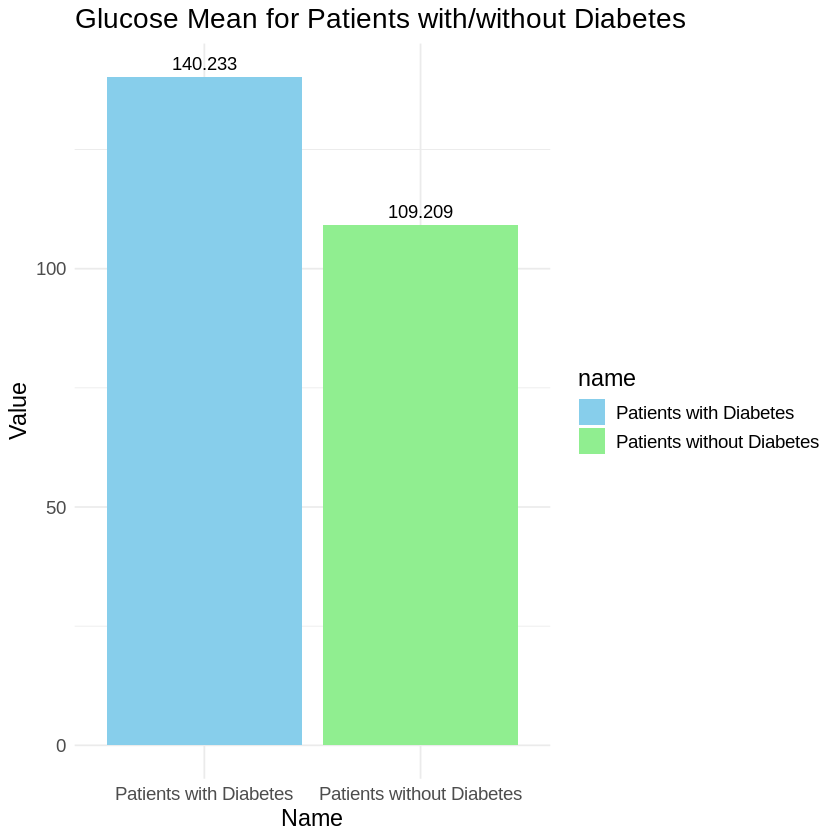

In [ ]:
ggplot(Q1, aes(x=name, y=value, fill = name)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = value), vjust = -0.5) +
   labs(title = "Glucose Mean for Patients with/without Diabetes",
       x = "Name",
       y = "Value", fill = "name") +
      scale_fill_manual(values = c("Patients with Diabetes" = "skyblue", "Patients without Diabetes" = "lightgreen")) +
      theme_minimal() +
      theme(text = element_text(size = 14))

### Conclusion 1: that the average glucose level in people with diabetes is higher than the average glucose level in people without diabetes with a difference of 30 that

## Q2 The average age of patients with and without diabetes.

In [ ]:
Age_mean_With_diabetes = round(mean(dataWithDiabetes$Age), digits = 0)

cat("The mean of Age column with diabetes: ", Age_mean_With_diabetes, "\n")

The mean of Age column with diabetes:  37 


In [ ]:
Age_mean_Without_diabetes = round(mean(dataWithoutDiabetes$Age), digits = 0)

cat("The mean of Age column without diabetes: ", Age_mean_Without_diabetes, "\n")

The mean of Age column without diabetes:  31 


In [ ]:
Q2 <- data.frame(
  name=c("Patients with Diabetes", "Patients without Diabetes") ,
  value=c(Age_mean_With_diabetes, Age_mean_Without_diabetes)
  )

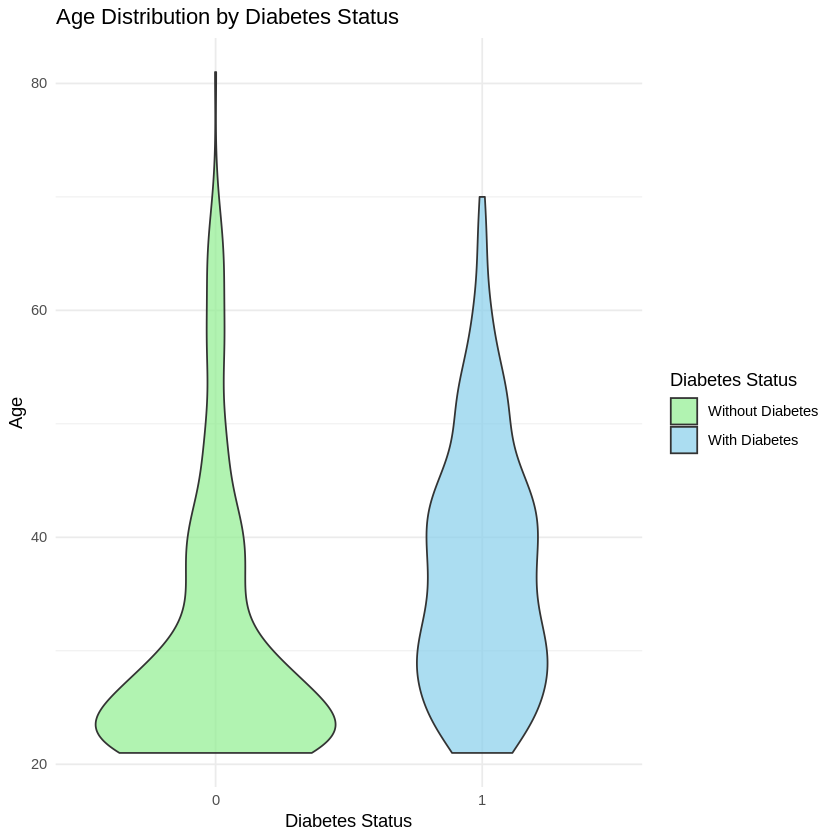

In [ ]:
ggplot(data, aes(x = factor(Outcome), y = Age, fill = factor(Outcome))) +
  geom_violin(alpha = 0.7) +
  labs(title = "Age Distribution by Diabetes Status",
       x = "Diabetes Status",
       y = "Age",
       fill = "Diabetes Status") +
  scale_fill_manual(values = c("lightgreen", "skyblue"),
                    labels = c("Without Diabetes", "With Diabetes")) +
  theme_minimal()


### Conclusion 2: Numerically it shows that the average age of people with diabetes is 37 and average age of people without diabetes is 31 and it is also shown by the violin graph that people ranging from 20 to 30 years mostly do not have diabetes however this percentage is lower in age above 30

### Q3 The average blood pressure measurements across diabetic and non-diabetic groups.

In [ ]:
BloodPressure_mean_With_diabetes = round(mean(dataWithDiabetes$BloodPressure), digits = 3)

cat("The mean of Blood Pressure column with diabetes: ", BloodPressure_mean_With_diabetes, "\n")

The mean of Blood Pressure column with diabetes:  75.628 


In [ ]:
BloodPressure_mean_Without_diabetes = round(mean(dataWithoutDiabetes$BloodPressure), digits = 3)

cat("The mean of Blood Pressure column without diabetes: ", BloodPressure_mean_Without_diabetes, "\n")

The mean of Blood Pressure column without diabetes:  70.772 


In [ ]:
Q3 <- data.frame(
  name=c("Blood Pressure with Diabetes", "Blood Pressure without Diabetes") ,
  value=c(BloodPressure_mean_With_diabetes, BloodPressure_mean_Without_diabetes)
  )

In [ ]:

Q3

name,value
<chr>,<dbl>
Blood Pressure with Diabetes,75.628
Blood Pressure without Diabetes,70.772


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


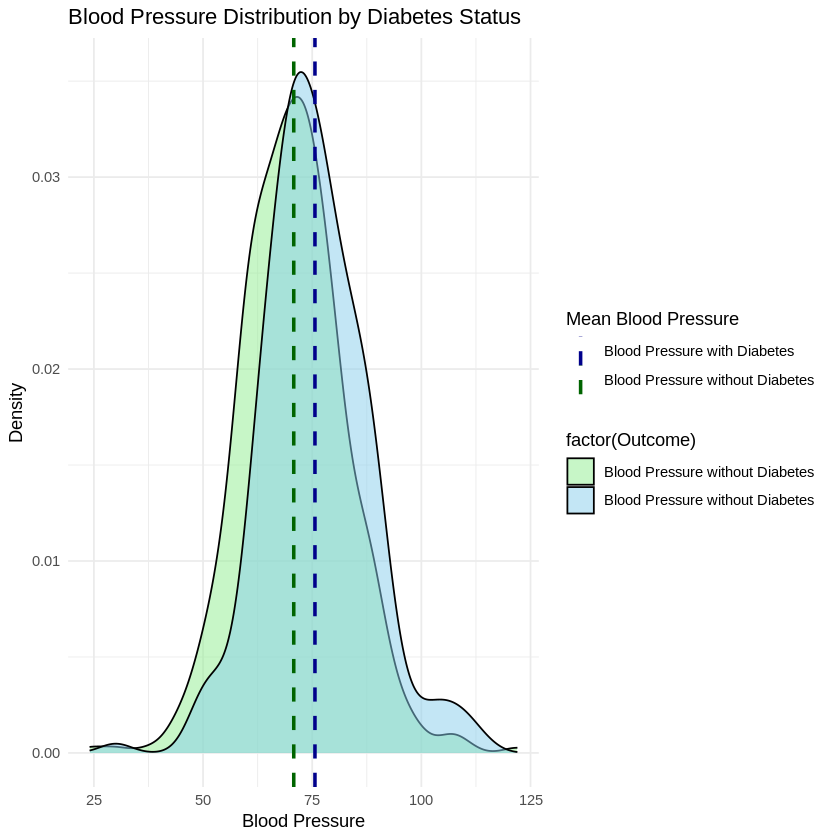

In [ ]:
ggplot(data, aes(x = BloodPressure, fill = factor(Outcome))) +
  geom_density(alpha = 0.5) +
  geom_vline(data = Q3, aes(xintercept = value, color = name),
             linetype = "dashed", size = 1) +
  labs(title = "Blood Pressure Distribution by Diabetes Status",
       x = "Blood Pressure",
       y = "Density",
       color = "Mean Blood Pressure") +
  scale_fill_manual(values = c("lightgreen", "skyblue"),
                    labels = c("Blood Pressure without Diabetes", "Blood Pressure without Diabetes")) +
  scale_color_manual(values = c("darkblue", "darkgreen"),
                     labels = c("Blood Pressure with Diabetes", "Blood Pressure without Diabetes")) +
  theme_minimal()


### Conclusion 3: The mean blood pressure for people with diabetes is 75.135 and the mean blood pressure for people without diabetes is 70.780 and also the plot shows the distribution of the blood pressure without diabess and the blood pressure with diabetes and highlighting the mean in the plot

## Q4 The average BMI of diabetic versus non-diabetic patients.

In [ ]:
BMI_mean_With_diabetes = round(mean(dataWithDiabetes$BMI), digits = 3)

cat("The mean of Blood Pressure column with diabetes: ", BMI_mean_With_diabetes, "\n")

The mean of Blood Pressure column with diabetes:  35.276 


In [ ]:
BMI_mean_Without_diabetes = round(mean(dataWithoutDiabetes$BMI), digits = 3)

cat("The mean of Blood Pressure column without diabetes: ", BMI_mean_Without_diabetes, "\n")

The mean of Blood Pressure column without diabetes:  30.626 


In [ ]:
BMI_varianceDiabetic = var(dataWithDiabetes$BMI)
cat("The variance of BMI column in data with diabetes: ", BMI_varianceDiabetic, "\n")

BMI_Stand_DevDiabetic = sd(dataWithDiabetes$BMI)
cat("The standard BMI column in data with diabetes: ", BMI_Stand_DevDiabetic, "\n")

The variance of BMI column in data with diabetes:  42.32427 
The standard BMI column in data with diabetes:  6.50571 


In [ ]:
BMI_varianceNonDiabetic = var(dataWithoutDiabetes$BMI)
cat("The variance of BMI column in data without diabetes: ", BMI_varianceNonDiabetic, "\n")

BMI_Stand_DevNonDiabetic = sd(dataWithoutDiabetes$BMI)
cat("The standard BMI column in data without diabetes: ", BMI_Stand_DevNonDiabetic, "\n")

The variance of BMI column in data without diabetes:  40.85932 
The standard BMI column in data without diabetes:  6.39213 


In [ ]:
Q4 <- data.frame(
  name=c("BMI with Diabetes", "BMI without Diabetes") ,
  value=c(BMI_mean_With_diabetes, BMI_mean_Without_diabetes)
  )

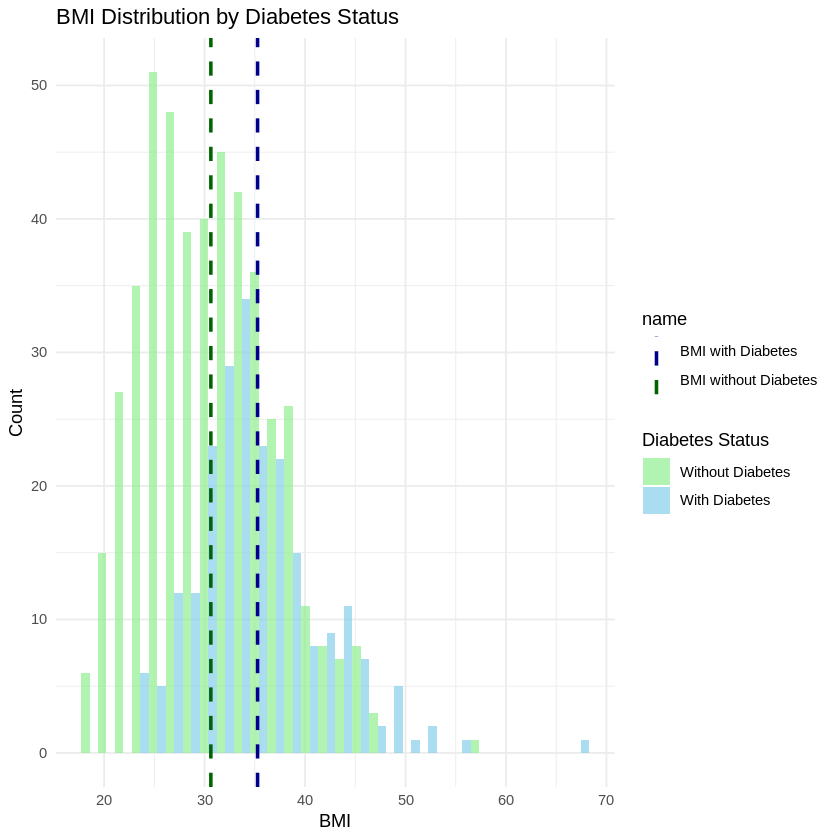

In [ ]:
ggplot(data, aes(x = BMI, fill = factor(Outcome))) +
  geom_histogram(position = "dodge", bins = 30, alpha = 0.7) +
  geom_vline(data = Q4, aes(xintercept = value, color = name),
             linetype = "dashed", size = 1) +
  labs(title = "BMI Distribution by Diabetes Status",
       x = "BMI",
       y = "Count",
       fill = "Diabetes Status") +
  scale_fill_manual(values = c("lightgreen", "skyblue"),
                    labels = c("Without Diabetes", "With Diabetes")) +
  scale_color_manual(values = c("darkblue", "darkgreen"),
                     labels = c("BMI with Diabetes", "BMI without Diabetes")) +
  theme_minimal()


### Conclusion 4: Numerically it is shown that the the mean BMI of people with diabetes is 35 and the mean BMI of peopl is 30 which means that BMI is higher in people with diabetes and it is shown by the histogram that the count of people with low BMI is higher in people without diabetes and the count if people with high BMI is higher is people with diabetes even so high diabetes even do not have values for people without diabetes

## Q5 The rate of diabetes among patients in the dataset.

In [ ]:
Q5 <- data.frame(
  Outcome=c(0, 1) ,
  Count=c(nrow(dataWithoutDiabetes), nrow(dataWithDiabetes)),
  Proportion = c( (nrow(dataWithoutDiabetes) / nrow(data)) * 100, (nrow(dataWithDiabetes) / (nrow(data))) * 100)
  )

In [ ]:
Q5

Outcome,Count,Proportion
<dbl>,<int>,<dbl>
0,473,67.47504
1,228,32.52496


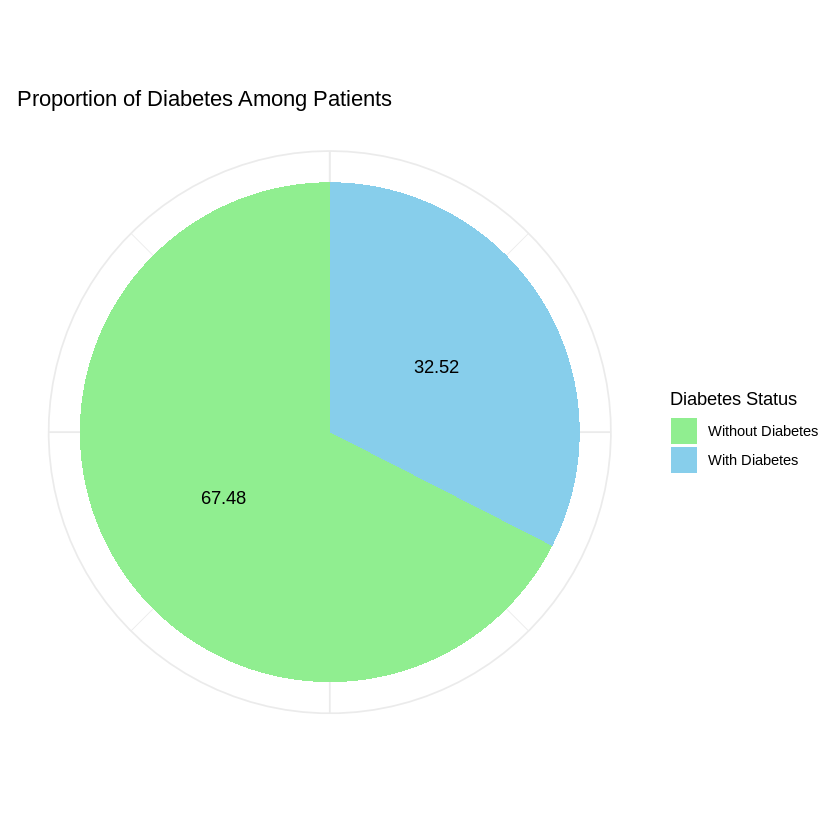

In [ ]:
ggplot(Q5, aes(x = "", y = Proportion, fill = factor(Outcome))) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y") +
  labs(title = "Proportion of Diabetes Among Patients",
       fill = "Diabetes Status") +
  scale_fill_manual(values = c("lightgreen", "skyblue"),
                    labels = c("Without Diabetes", "With Diabetes")) +
  geom_text(aes(label = round(Proportion, digits = 2)),
            position = position_stack(vjust = 0.5)) +
  theme_minimal() +
  theme(axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_blank())


### Conclusion 5: This indicates that approximately one-third of the patients in the dataset are affected by diabetes, while the majority (two-thirds) do not have the condition. The rate of diabetes among patients is therefore 32.52%.

## Q6 The distribution of BMI values among all patients.

In [ ]:
meanBMI = round(mean(data$BMI), digits = 3)

In [ ]:
cat("The mean of BMI column for all Patients: ", meanBMI, "\n")

The mean of BMI column for all Patients:  32.139 


In [ ]:
BMI_variance = var(data$BMI)
cat("The variance of BMI column in data : ", BMI_variance, "\n")

BMI_Stand_Dev = sd(data$BMI)
cat("The standard BMI column in data: ", BMI_Stand_Dev, "\n")

The variance of BMI column in data :  46.02744 
The standard BMI column in data:  6.784352 


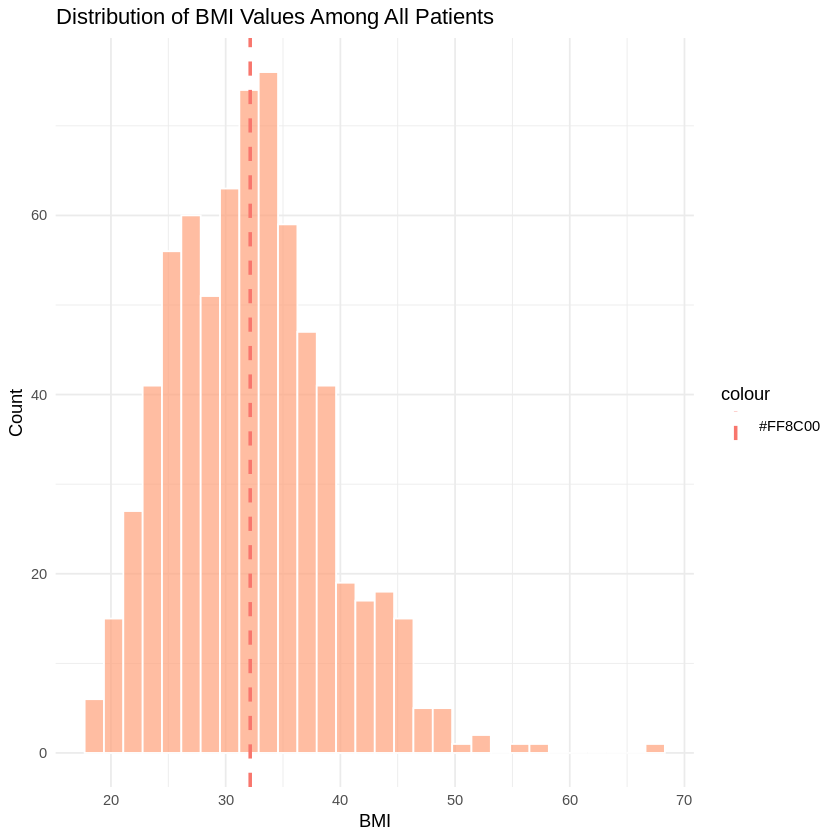

In [ ]:
ggplot(data, aes(x = BMI)) +
  geom_histogram(bins = 30, fill = "#FFA07A" , color = "white", alpha = 0.7) +
  geom_vline( aes(xintercept = meanBMI, color = "#FF8C00"),
             linetype = "dashed", size = 1) +
  labs(title = "Distribution of BMI Values Among All Patients",
       x = "BMI",
       y = "Count") +
  theme_minimal()


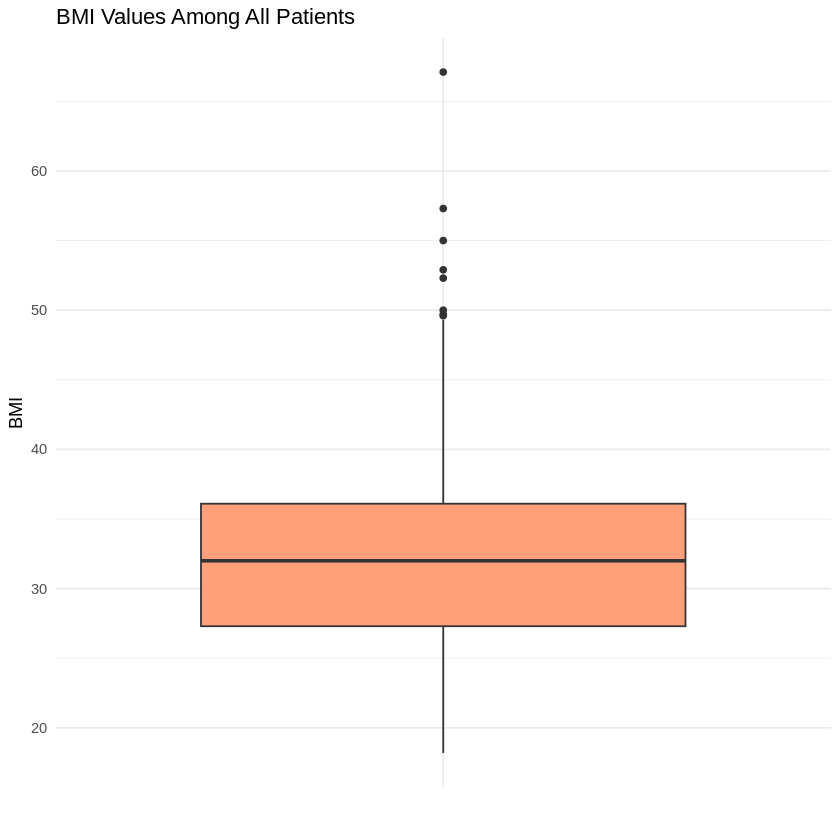

In [ ]:
ggplot(data, aes(x = "", y = BMI)) +
  geom_boxplot(fill = "#FFA07A") +
  labs(title = "BMI Values Among All Patients",
       x = "",
       y = "BMI") +
  theme_minimal()


### Conclusion 6: The Histogram shows that most patients in the dataset hase BMI distribution from 25 to 40 and the mean is nearly 32 and it is shown in the boxplot that the min value is nearly 27 and the max is 36 except of some outliers that has BMI more than that

## The distribution of Diabetes Pedigree Function (DPF) values for diabetic and non-diabetic patients.

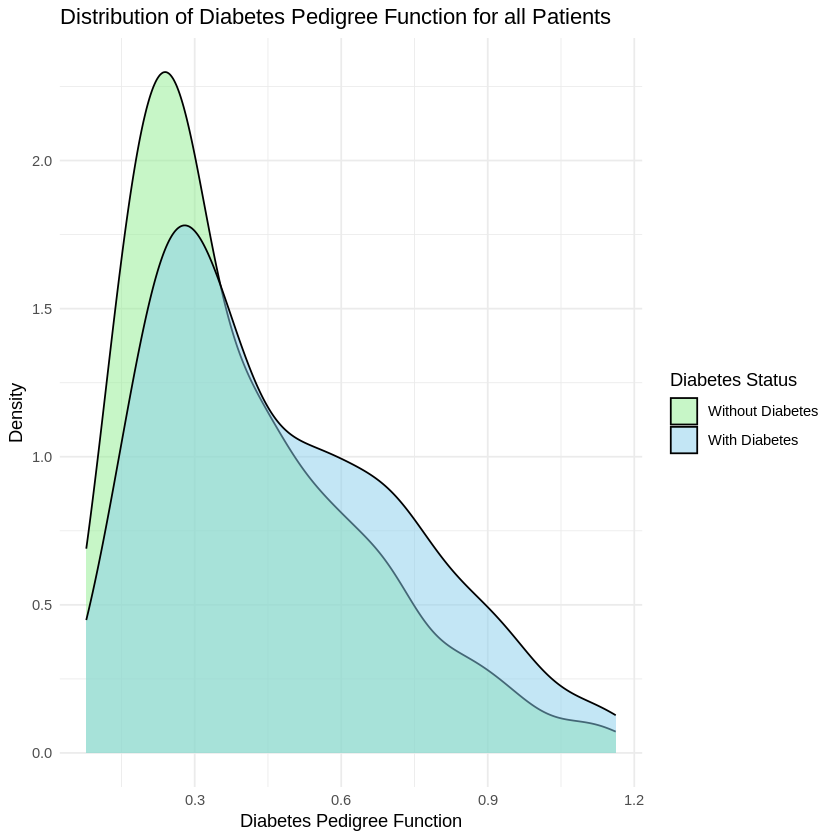

In [ ]:
ggplot(data, aes(x = DiabetesPedigreeFunction, fill = factor(Outcome))) +
  geom_density(alpha = 0.5) +
  labs(title = "Distribution of Diabetes Pedigree Function for all Patients",
       x = "Diabetes Pedigree Function",
       y = "Density",
       fill = "Diabetes Status") +
  scale_fill_manual(values = c("lightgreen", "skyblue"),
                    labels = c("Without Diabetes", "With Diabetes")) +
  theme_minimal()


### The Density plot shows that the density high for patients without diabetes when diabetes degree function is low and by increasing the diabetes degree function the density of patients without diabetes decrease and the density of patients with diabetes increase

## The relationship between the number of pregnancies and diabetes occurrence.

In [ ]:
cor.test(data$Pregnancies, data$Outcome)



	Pearson's product-moment correlation

data:  data$Pregnancies and data$Outcome
t = 6.2102, df = 699, p-value = 9.081e-10
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1572795 0.2976758
sample estimates:
      cor 
0.2286663 


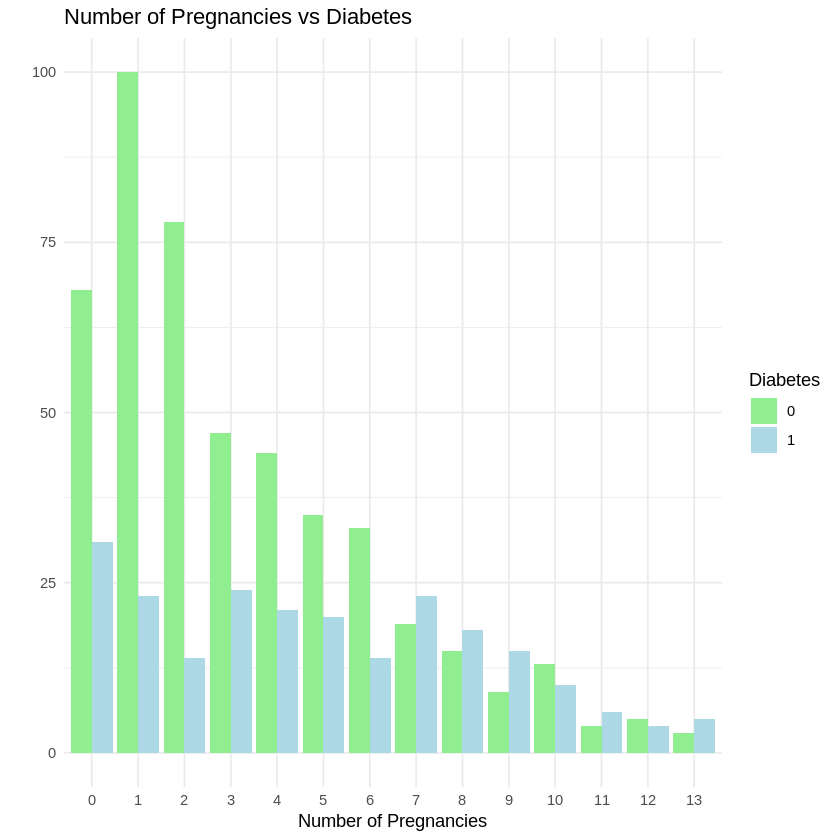

In [ ]:
# as.factor to help me categorize the patients to 0, 1 or categories in outcome and see the count in each one to show grouped bar
ggplot(data, aes(x = as.factor(Pregnancies), fill = as.factor(Outcome))) +
  geom_bar(position = "dodge") +
  labs(title = "Number of Pregnancies vs Diabetes",
       x = "Number of Pregnancies",
       y = "",
       fill = "Diabetes") +
  scale_fill_manual(values = c("lightgreen", "lightblue")) +
  theme_minimal()


## The plot shows that as the number of pregnancy increase the proportion between patients with diabetes and without decrease for example 1 pregnancy show difference between of nearly 75% between patients with diabetes and without ;however, at 6 pregnancy it shows nearly differnce of 10%.

## There is a significant, weak positive correlation between the number of pregnancies and the likelihood of having diabetes. The correlation coefficient of 0.23 suggests that as the number of pregnancies increases, the probability of a positive diabetes outcome (Outcome = 1) slightly increases.

## The correlation between glucose levels and BMI.

In [ ]:
correlation <- cor(data$Glucose, data$BMI)

print(correlation)

[1] 0.2059253


`geom_smooth()` using formula = 'y ~ x'


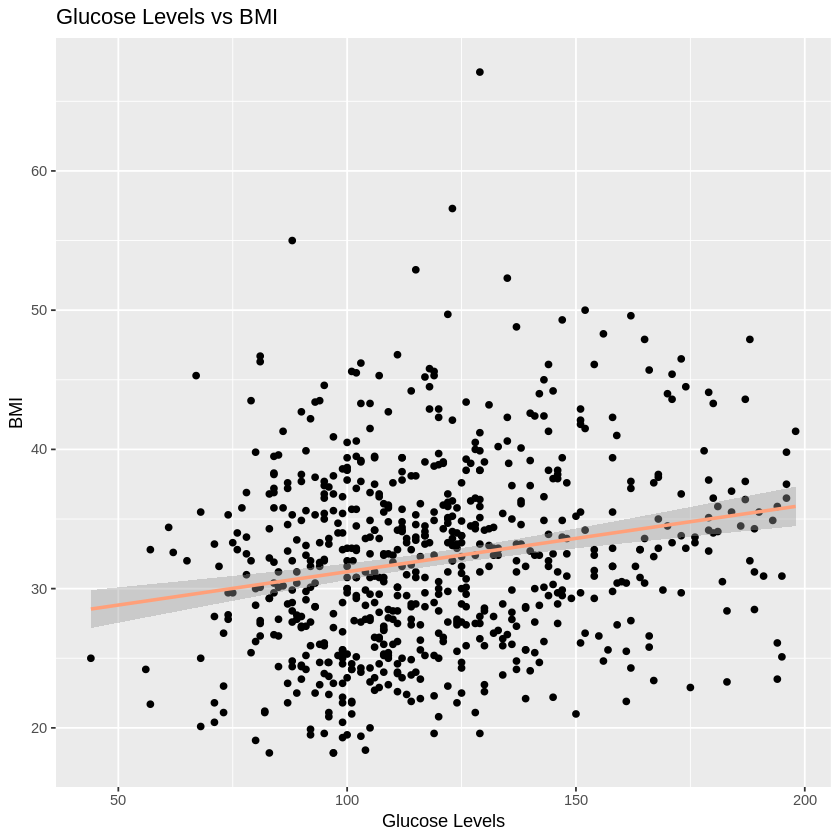

In [ ]:
ggplot(data = data, aes(x = Glucose, y = BMI)) +
  geom_point() +
  stat_smooth(method = lm, col = "#FFA07A") +
  labs(title = "Glucose Levels vs BMI",
       x = "Glucose Levels",
       y = "BMI")

### There is a weak positive correlation between glucose levels and BMI, as indicated by the slightly upward-sloping trend line. This is proved numerically as the correlation is 0.2 which is a very week correlation.

## The trend of glucose levels with age among diabetic and non-diabetic patients.

In [ ]:
correlation <- cor(data$Glucose, data$Age)

print(correlation)

[1] 0.286501


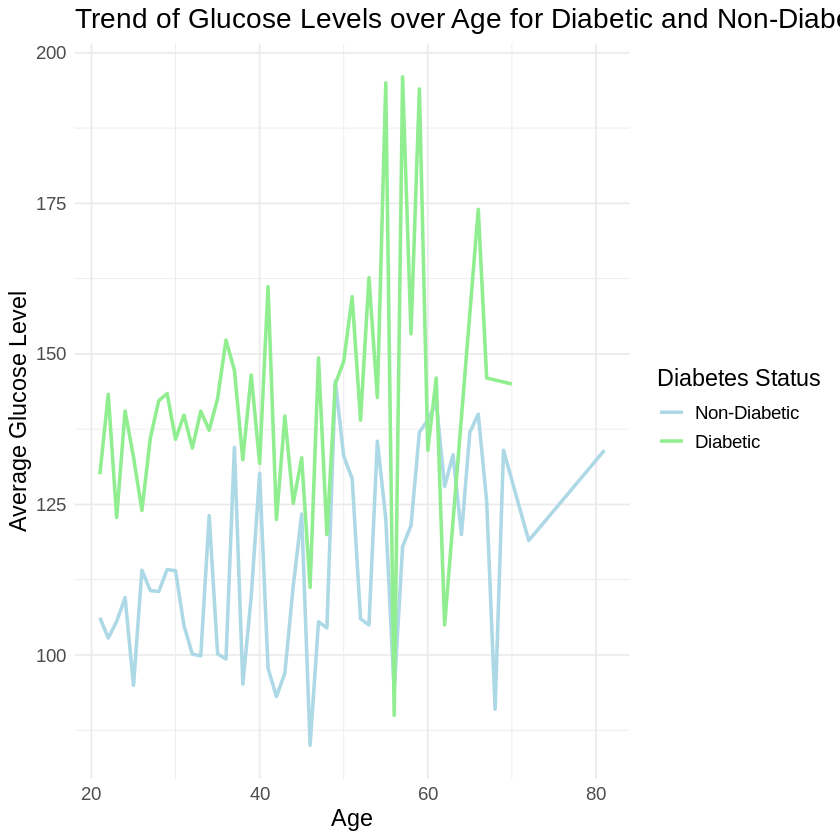

In [ ]:
plot <- ggplot(data, aes(x = Age, y = Glucose, color = factor(Outcome))) +
  geom_line(stat = "summary", fun = "mean", size = 1) +
  labs(title = "Trend of Glucose Levels over Age for Diabetic and Non-Diabetic Patients", x = "Age", y = "Average Glucose Level", color = "Diabetes Status") +
  scale_color_manual(values = c("lightblue", "lightgreen"), labels = c("Non-Diabetic", "Diabetic")) +
  theme_minimal()+
  theme(text = element_text(size = 14))

print(plot)

options(repr.plot.width = 25)  # Adjusting width of the figure


### The trend in the line plot shows that Diabetic patients consistently show higher glucose levels compared to non-diabetic patients
### Non-diabetic patients maintain more stable glucose levels, typically ranging between 100-125 however there is some variances
### The data shows that glucose control becomes more challenging for diabetic patients in their late 50s and early 60s as there is high variances as shown by the chart
## Numerically there is a weak positive correlation between Age and Glucose

In [ ]:
# coverage_data <- data.frame(
#   SampleSize = c(15, 100, 10),
#   Coverage = c(coverage_15, coverage_100, coverage_10)
# )

# ggplot(coverage_data, aes(x = factor(SampleSize), y = Coverage, fill = factor(SampleSize))) +
#   geom_bar(stat = "identity") +
#   labs(title = "Coverage Proportions for Different Sample Sizes",
#        x = "Sample Size", y = "Coverage Proportion") +
#   theme_minimal()



*  Q: Does the width of the confidence intervals increase or decrease?
  *  A: Decreases as the sample size increases.



*  Q: Does increasing the sample size result in more or fewer intervals containing the true population mean?
  * A:  More intervals contain the true population mean as the sample size increases, with coverage approaching 95%.











# PART 2: Answering Questions

## 2.1. Use the appropriate statistics and plots to answer the following questions:


### 2.1.1. Are higher glucose levels associated with a greater likelihood of diabetes?

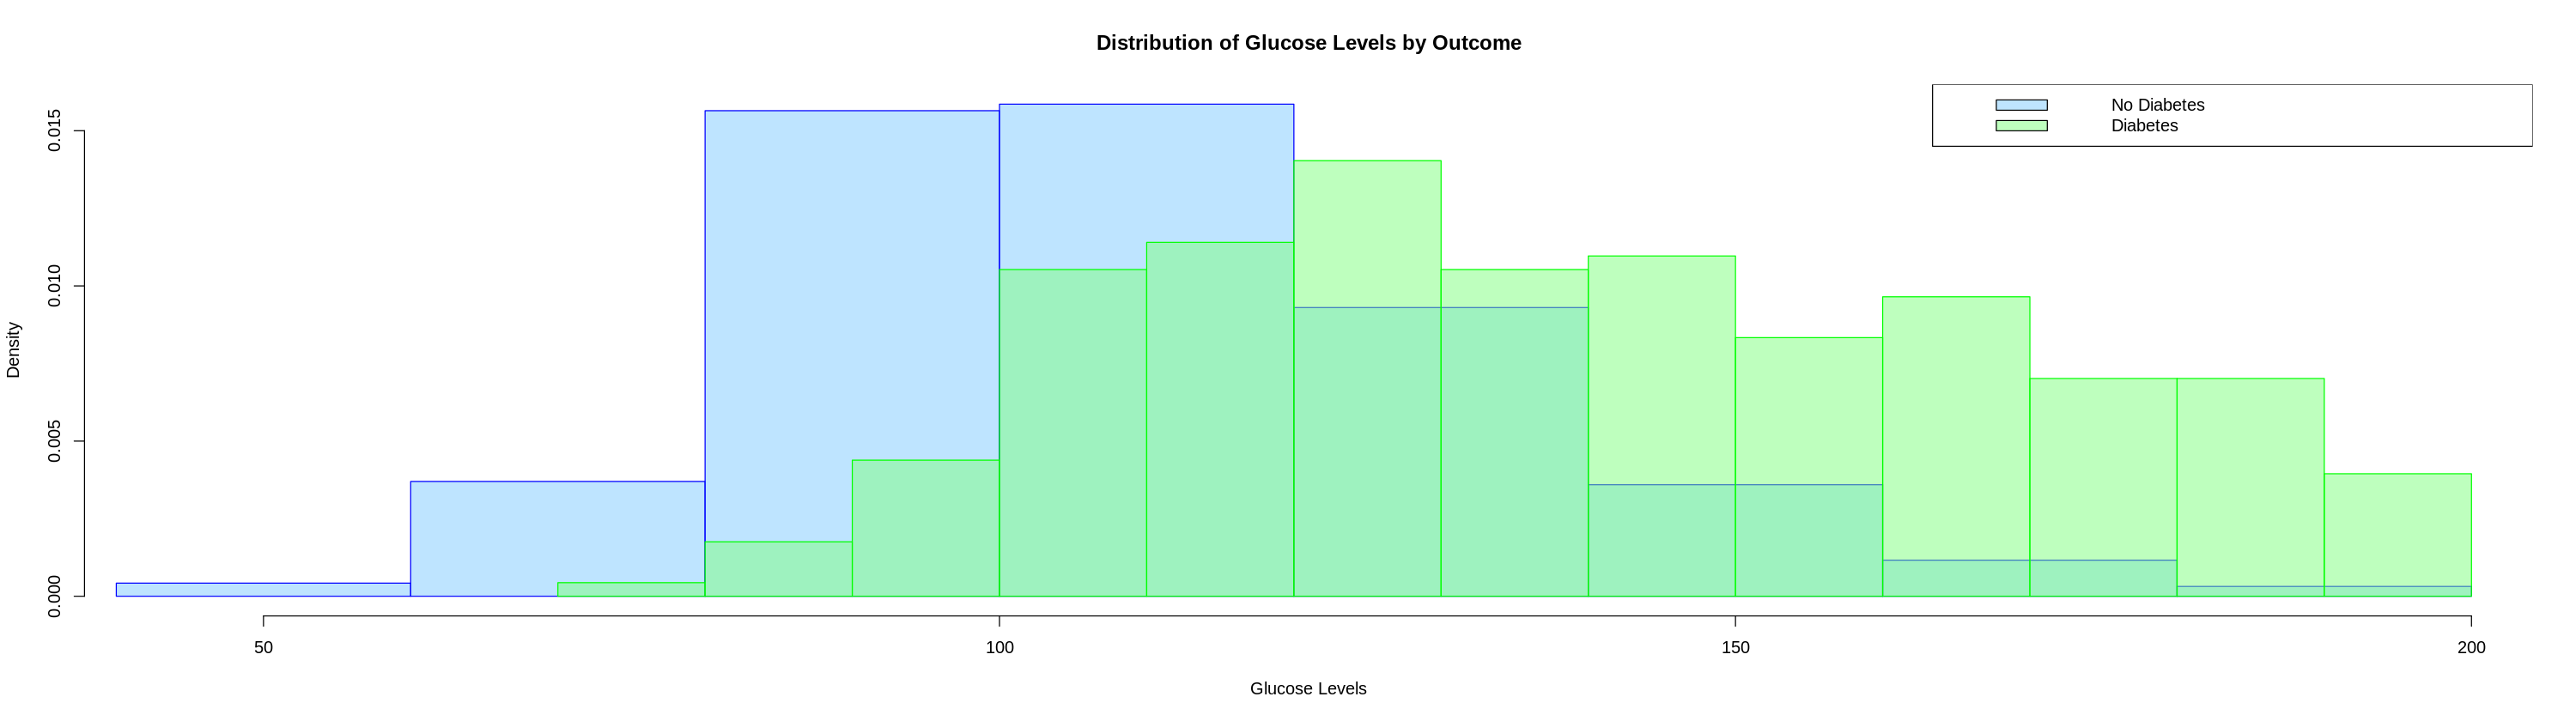

In [ ]:
hist(data$Glucose[data$Outcome == 0],
     main = "Distribution of Glucose Levels by Outcome",
     xlab = "Glucose Levels",
     col = rgb(0.5, 0.8, 1, 0.5),
     border = "blue",
     freq = FALSE,
     xlim = range(data$Glucose))
hist(data$Glucose[data$Outcome == 1],
     col = rgb(0.5, 1, 0.5, 0.5),
     border = "green",
     freq = FALSE,
     add = TRUE)
legend("topright", legend = c("No Diabetes", "Diabetes"),
       fill = c(rgb(0.5, 0.8, 1, 0.5), rgb(0.5, 1, 0.5, 0.5)))

* Individuals without diabetes generally have glucose levels concentrated in the lower range, peaking between 80 and 110. (Normal)
* Individuals with diabetes exhibit a broader distribution, with glucose levels skewed towards higher values, often exceeding 120.

**Conclusion:** Higher glucose levels are more strongly associated with diabetes

This supports the hypothesis that elevated glucose levels increase the likelihood of diabetes.

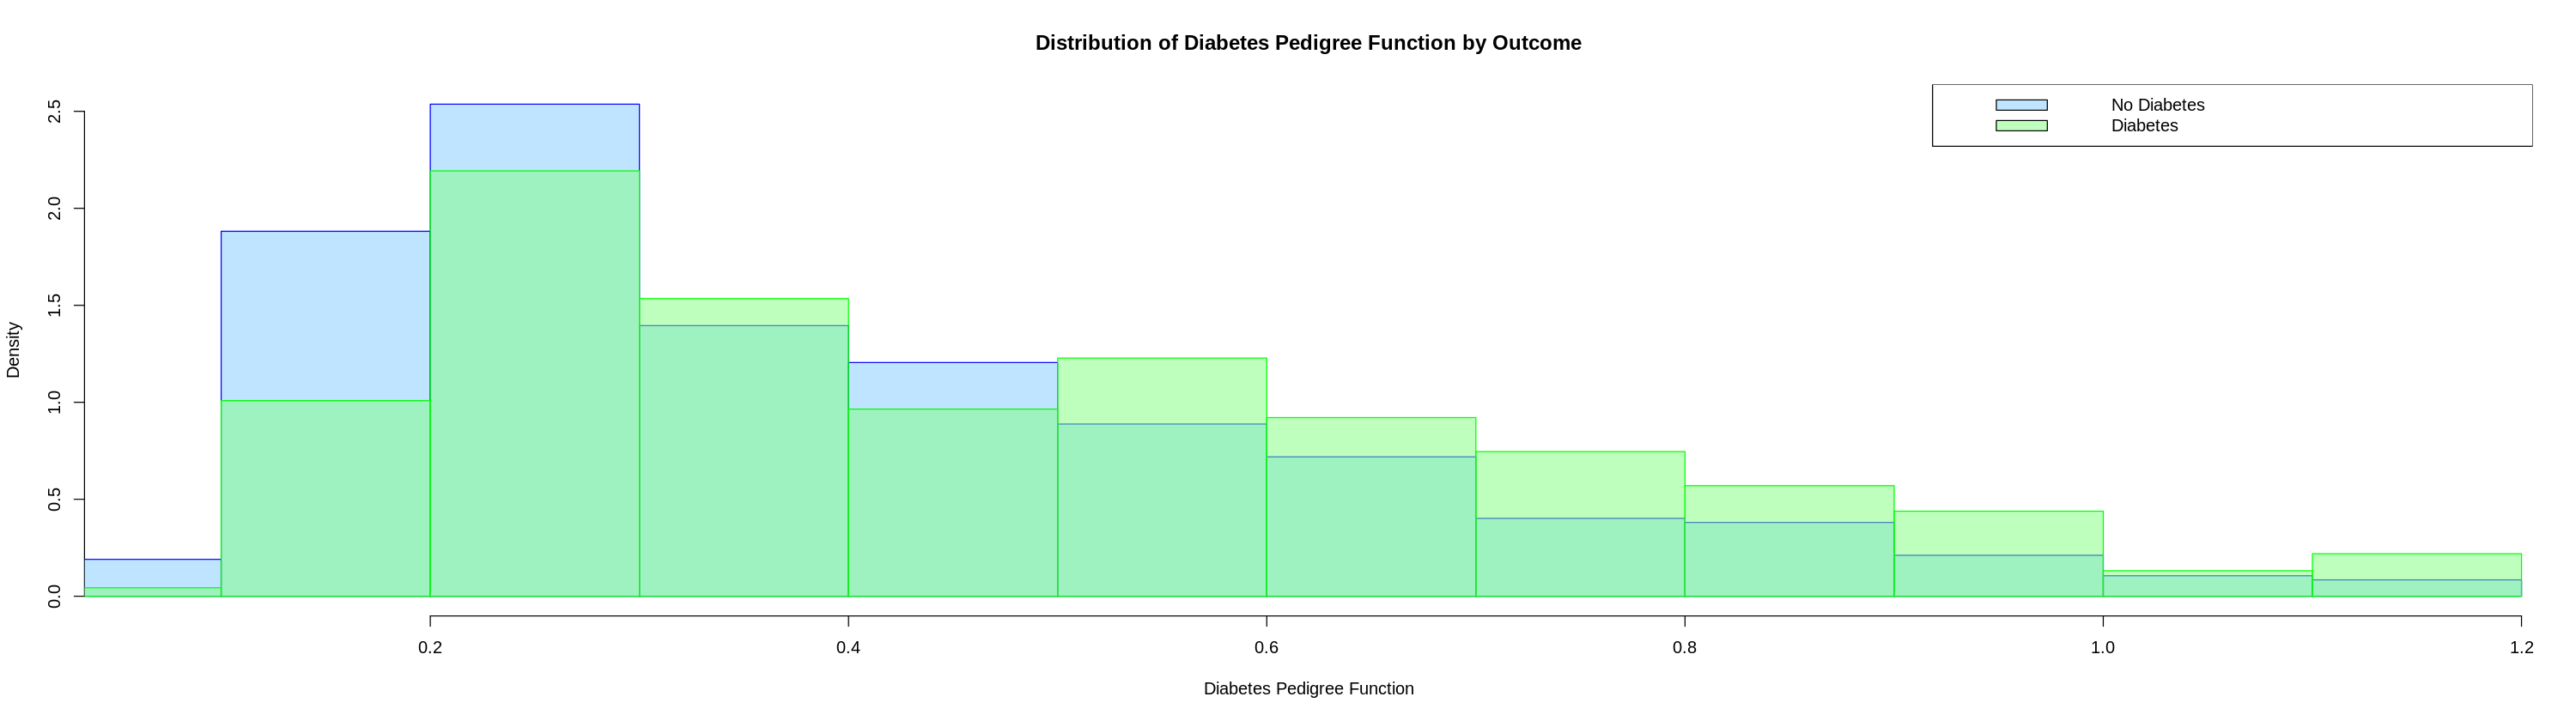

In [ ]:
hist(data$DiabetesPedigreeFunction[data$Outcome == 0],
     main = "Distribution of Diabetes Pedigree Function by Outcome",
     xlab = "Diabetes Pedigree Function",
     col = rgb(0.5, 0.8, 1, 0.5),
     border = "blue",
     freq = FALSE,
     xlim = range(data$DiabetesPedigreeFunction))
hist(data$DiabetesPedigreeFunction[data$Outcome == 1],
     col = rgb(0.5, 1, 0.5, 0.5),
     border = "green",
     freq = FALSE,
     add = TRUE)
legend("topright", legend = c("No Diabetes", "Diabetes"),
       fill = c(rgb(0.5, 0.8, 1, 0.5), rgb(0.5, 1, 0.5, 0.5)))

* For individuals without diabetes, the distribution of values is concentrated towards the lower range, with most values below 0.5.
* Individuals with diabetes exhibit a broader spread, with higher frequencies at values above 0.5, and a tail extending to higher values.

**Conclusion:** Higher Diabetes Pedigree Function values are associated with a greater likelihood of diabetes.

The histograms suggest that individuals with a stronger family history of diabetes or higher genetic predisposition are more likely to have diabetes.

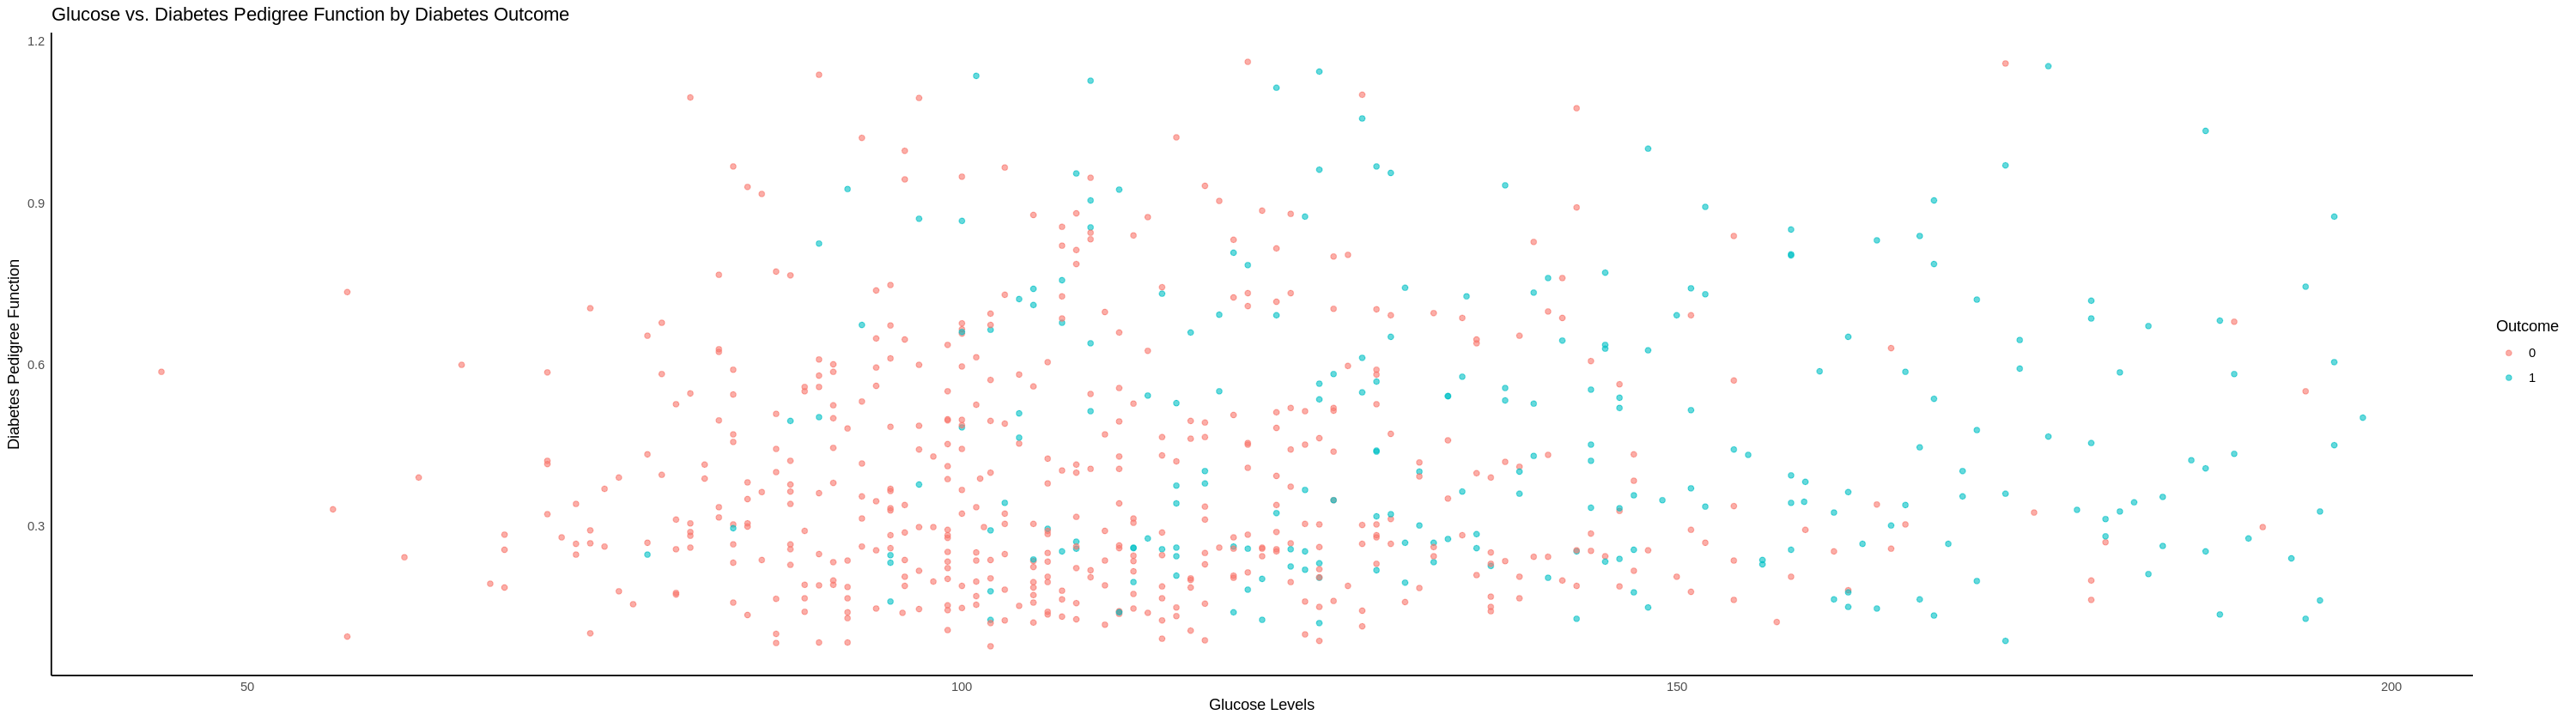

In [ ]:
library(ggplot2)

ggplot(data, aes(x = Glucose, y = DiabetesPedigreeFunction, color = factor(Outcome))) +
  geom_point(alpha = 0.6) +
  labs(title = "Glucose vs. Diabetes Pedigree Function by Diabetes Outcome",
       x = "Glucose Levels",
       y = "Diabetes Pedigree Function",
       color = "Outcome") +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.line = element_line(color = "black"))

* There appears to be a positive association between higher glucose levels and the likelihood of having diabetes. Specifically, individuals with higher glucose levels above 120 are more likely to have diabetes
* Conversely, lower glucose levels below 100 are more associated with having diabetes.

Perform t-test to compare Glucose levels between Outcome groups

In [ ]:
t_test_glucose <- t.test(Glucose ~ Outcome, data = data)
t_test_glucose


	Welch Two Sample t-test

data:  Glucose by Outcome
t = -14.195, df = 379.32, p-value < 2.2e-16
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -35.32242 -26.72725
sample estimates:
mean in group 0 mean in group 1 
       109.2086        140.2334 


* t-value: -14.195, indicating a large difference between group means.
* p-value: < 2.2e-16, which is highly significant, rejecting the null hypothesis.

**Conclusion:** There is a significant difference in glucose levels between the two groups, with higher glucose levels in the diabetes group.

Perform t-test to compare DiabetesPedigreeFunction values between Outcome groups

In [ ]:
t_test_dpf <- t.test(DiabetesPedigreeFunction ~ Outcome, data = data)
t_test_dpf


	Welch Two Sample t-test

data:  DiabetesPedigreeFunction by Outcome
t = -4.0092, df = 412.9, p-value = 7.23e-05
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.11973537 -0.04095043
sample estimates:
mean in group 0 mean in group 1 
      0.3977273       0.4780702 


* t-value: -4.0092, indicating a noticeable difference between group means.
* p-value: 7.23e-05, which is highly significant, rejecting the null hypothesis.

**Conclusion:** There is a significant difference in Diabetes Pedigree Function values between the two groups, with higher values in the diabetes group.

In [ ]:
correlation <- cor.test(data$Glucose, data$DiabetesPedigreeFunction)
correlation


	Pearson's product-moment correlation

data:  data$Glucose and data$DiabetesPedigreeFunction
t = 1.6212, df = 699, p-value = 0.1054
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.01290321  0.13464490
sample estimates:
      cor 
0.0612052 


**Correlation Coefficient (cor = 0.0612052):**
* The correlation coefficient between Glucose and Diabetes Pedigree Function is 0.061, indicating a very weak positive correlation.

**P-value (p-value = 0.1054):**
* The p-value is greater than 0.05, indicating that the result is not statistically significant.
* This means we fail to reject the null hypothesis, and there is no strong evidence to suggest a meaningful correlation between Glucose and Diabetes Pedigree Function.

**95% Confidence Interval (-0.01290321 to 0.13464490):**
* The confidence interval includes 0, which further supports that the correlation might not be significantly different from 0.
* This reflects high uncertainty in the strength and direction of the relationship.

**t-Statistic (t = 1.6212) and Degrees of Freedom (df = 699):**
* The t-statistic quantifies the strength of evidence against the null hypothesis. Here, the value is small (1.62), suggesting weak evidence.

**Conclusion**
* There is insufficient evidence to conclude that higher glucose levels are strongly associated with a greater likelihood of diabetes based on the available data.

### 2.1.2. Are patients with high glucose concentrations also likely to have higher BMI values?

BMI vs Glucose relationship

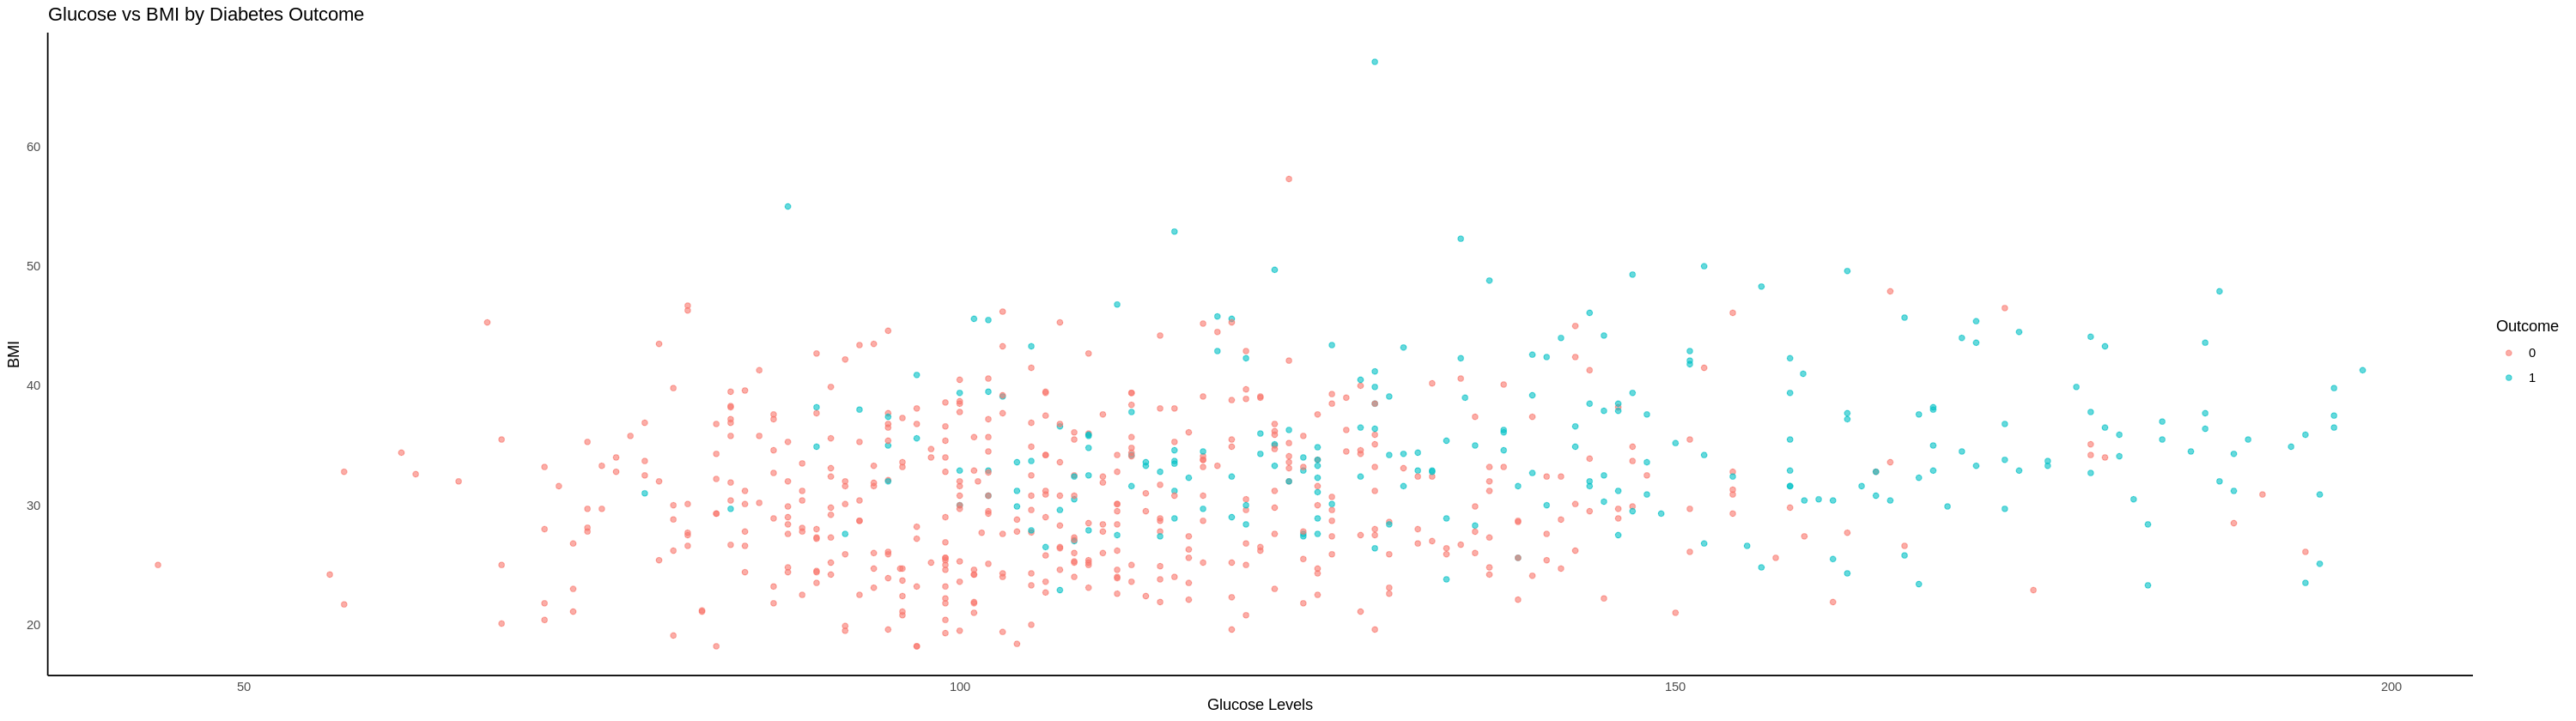

In [ ]:
ggplot(data, aes(x = Glucose, y = BMI, color = factor(Outcome))) +
  geom_point(alpha = 0.6) +
  labs(title = "Glucose vs BMI by Diabetes Outcome",
       x = "Glucose Levels",
       y = "BMI",
       color = "Outcome") +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.line = element_line(color = "black"))

It appears that there is no strong or clear trend indicating that higher glucose levels are consistently associated with higher BMI values.

Visualize the BMI differences across Glucose categories.

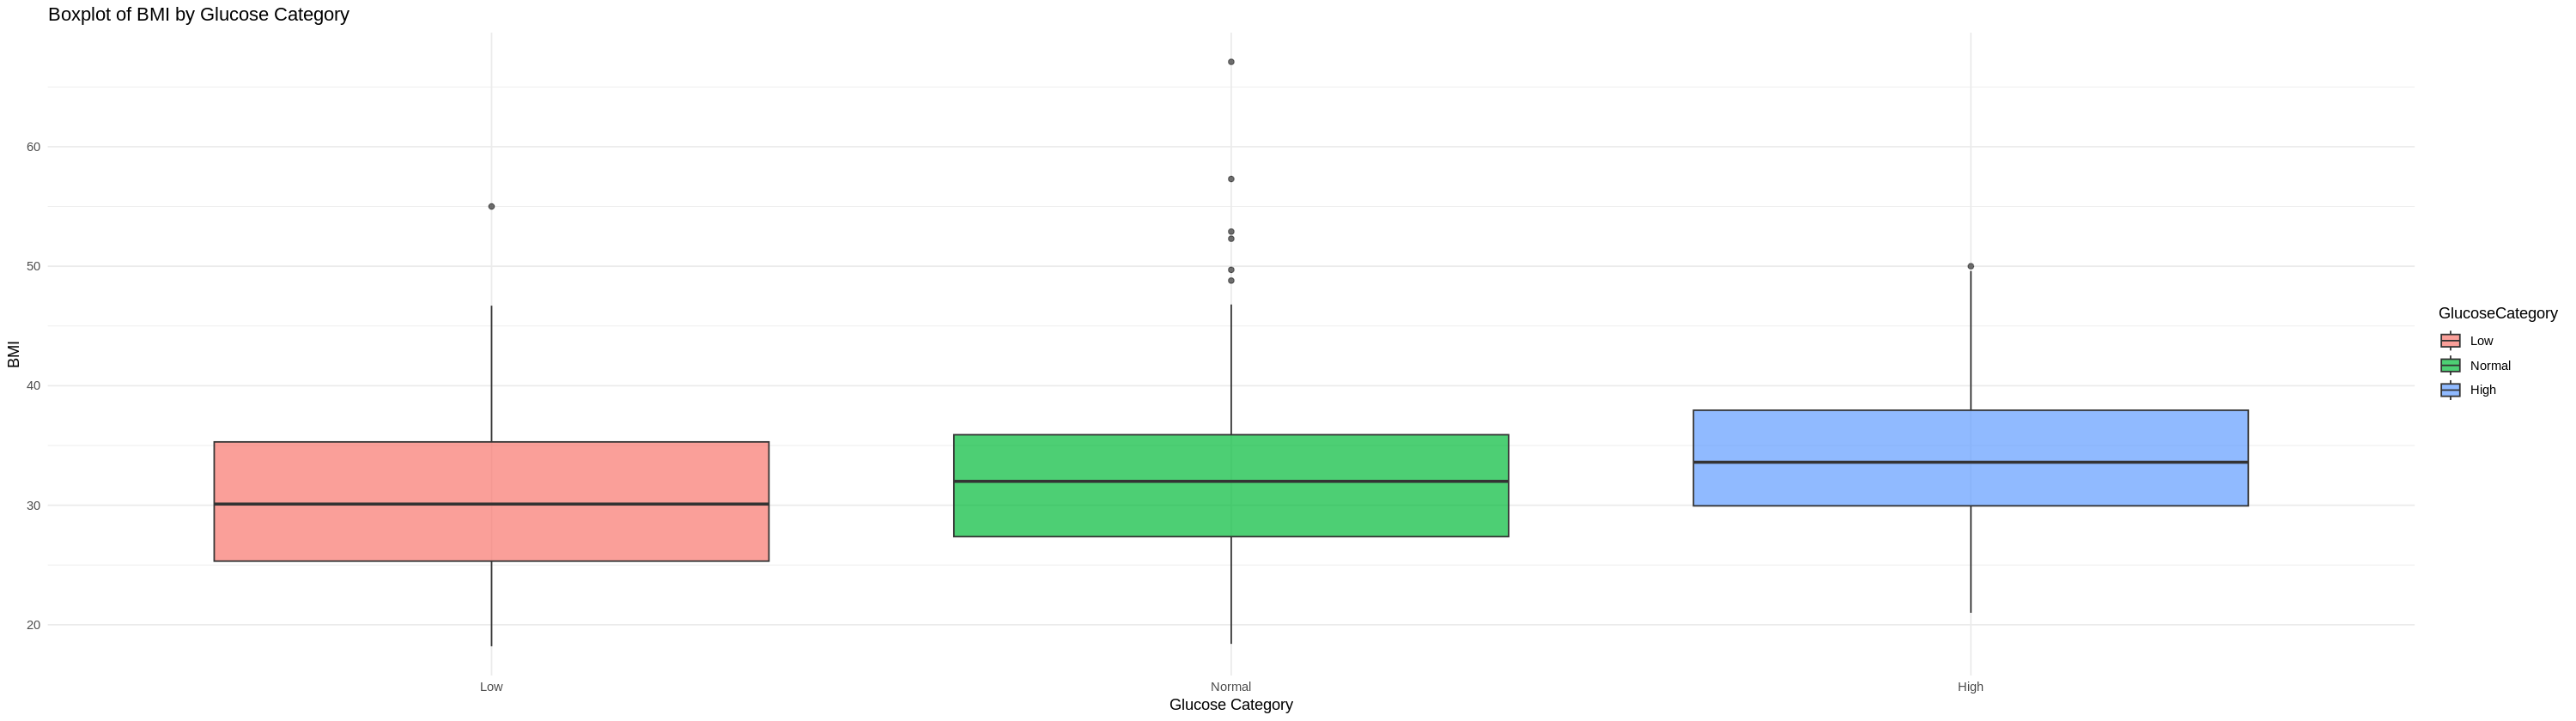

In [ ]:
data$GlucoseCategory <- cut(data$Glucose,
                            breaks = c(-Inf, 100, 140, Inf),
                            labels = c("Low", "Normal", "High"))

ggplot(data, aes(x = GlucoseCategory, y = BMI, fill = GlucoseCategory)) +
  geom_boxplot(alpha = 0.7) +
  labs(title = "Boxplot of BMI by Glucose Category",
       x = "Glucose Category",
       y = "BMI") +
  theme_minimal()

It appears that there is a slight association between higher glucose levels with higher BMI values.

Perform correlation analysis between Glucose and BMI

In [ ]:
correlation <- cor.test(data$Glucose, data$BMI)
correlation


	Pearson's product-moment correlation

data:  data$Glucose and data$BMI
t = 5.5636, df = 699, p-value = 3.766e-08
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1339174 0.2757701
sample estimates:
      cor 
0.2059253 


**Correlation Coefficient (cor = 0.2059253):**
* This indicates a **weak positive correlation**, meaning that as Glucose levels increase, BMI tends to increase slightly, but the relationship is not very strong.

**P-value (p-value = 3.766e-08):**
* This result is statistically significant, so we can confidently reject the null hypothesis that there is no correlation.

**95% Confidence Interval (0.1339174 to 0.2757701):**
* The true correlation is estimated to lie between 0.134 and 0.276 with 95% confidence.

**t-Statistic (t = 5.5636) and Degrees of Freedom (df = 699):**
* The t-statistic quantifies the strength of evidence against the null hypothesis, and here it is quite large (5.56).

**Conclusion:**
* There is a statistically significant but weak positive correlation between Glucose levels and BMI.
* Higher Glucose levels are associated with slightly higher BMI, but the relationship is not strong enough to make reliable predictions.

### 2.1.3. Are patients with a higher number of pregnancies at greater risk of developing diabetes?


Proportion of Diabetes by Number of Pregnancies

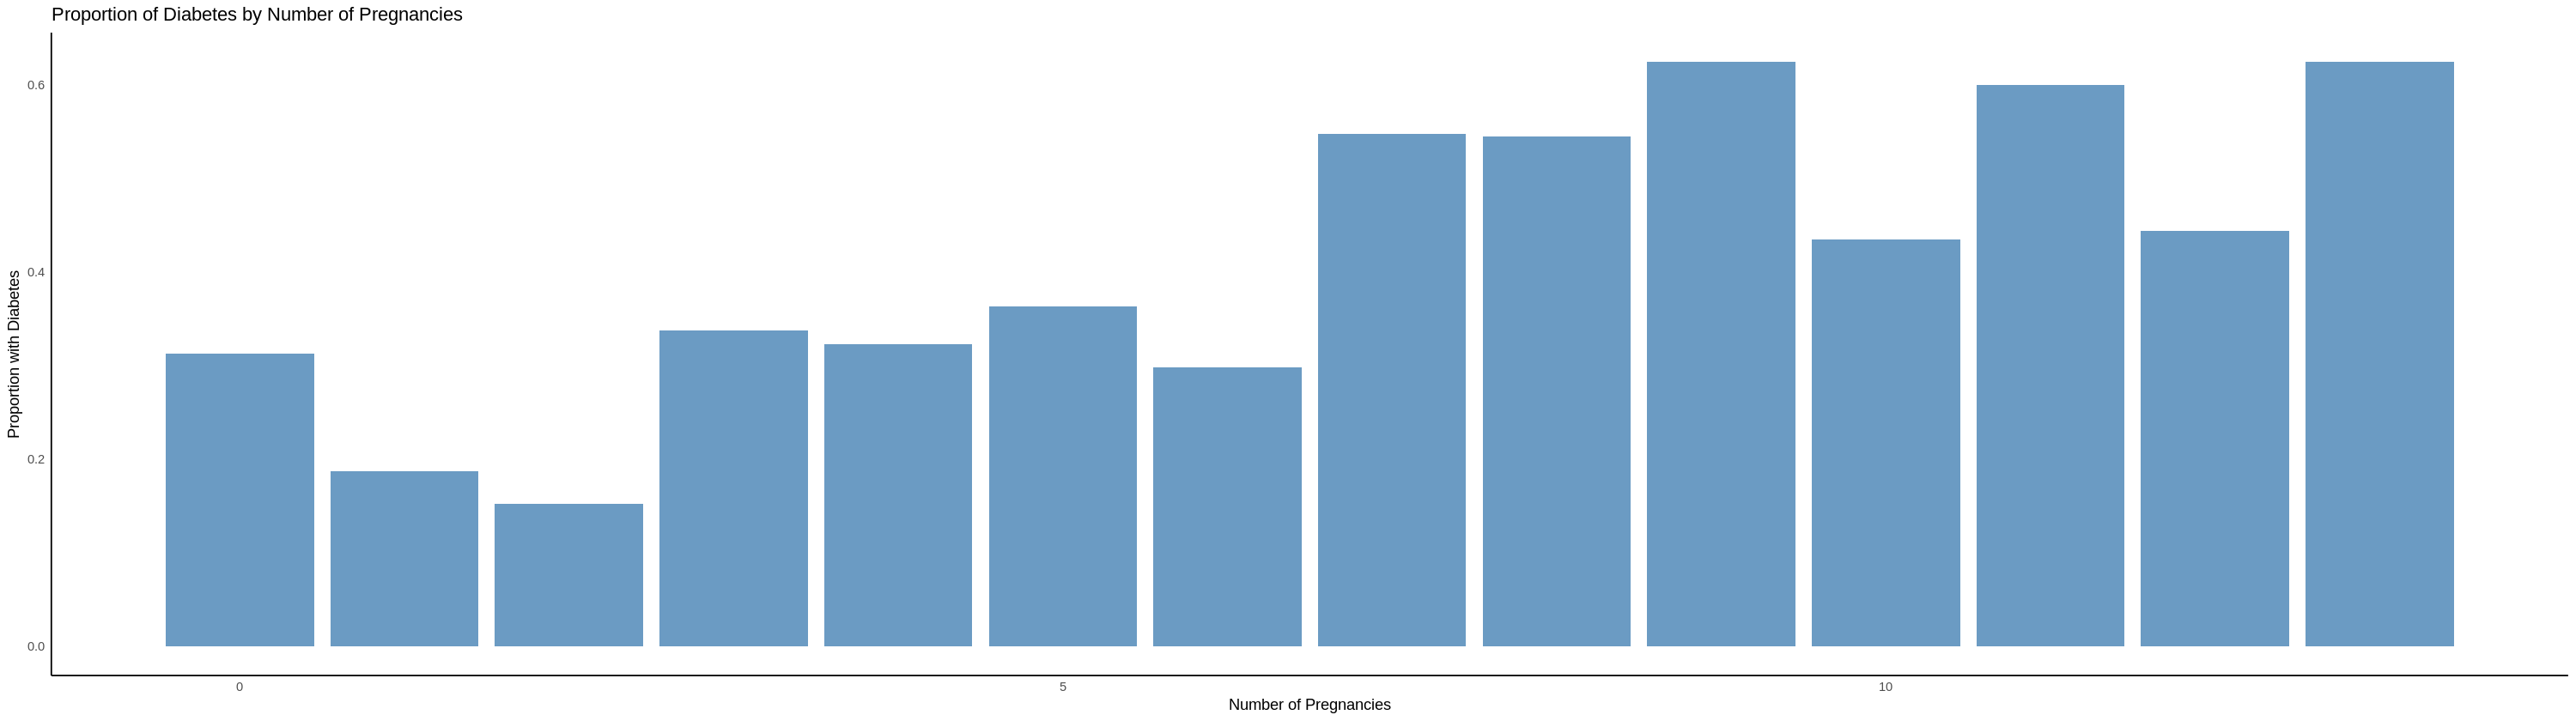

In [ ]:
pregnancy_risk <- data %>%
  group_by(Pregnancies) %>%
  summarize(Proportion_Diabetes = mean(Outcome),
            Count = n())

ggplot(pregnancy_risk, aes(x = Pregnancies, y = Proportion_Diabetes)) +
  geom_bar(stat = "identity", fill = "steelblue", alpha = 0.8) +
  labs(title = "Proportion of Diabetes by Number of Pregnancies",
       x = "Number of Pregnancies",
       y = "Proportion with Diabetes") +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.line = element_line(color = "black")
  )

* The proportion of patients with diabetes tends to increase as the number of pregnancies increases.
* Patients with higher numbers of pregnancies 10 or more appear to have a higher proportion of diabetes.

Boxplot of Pregnancies vs Diabetes Outcome

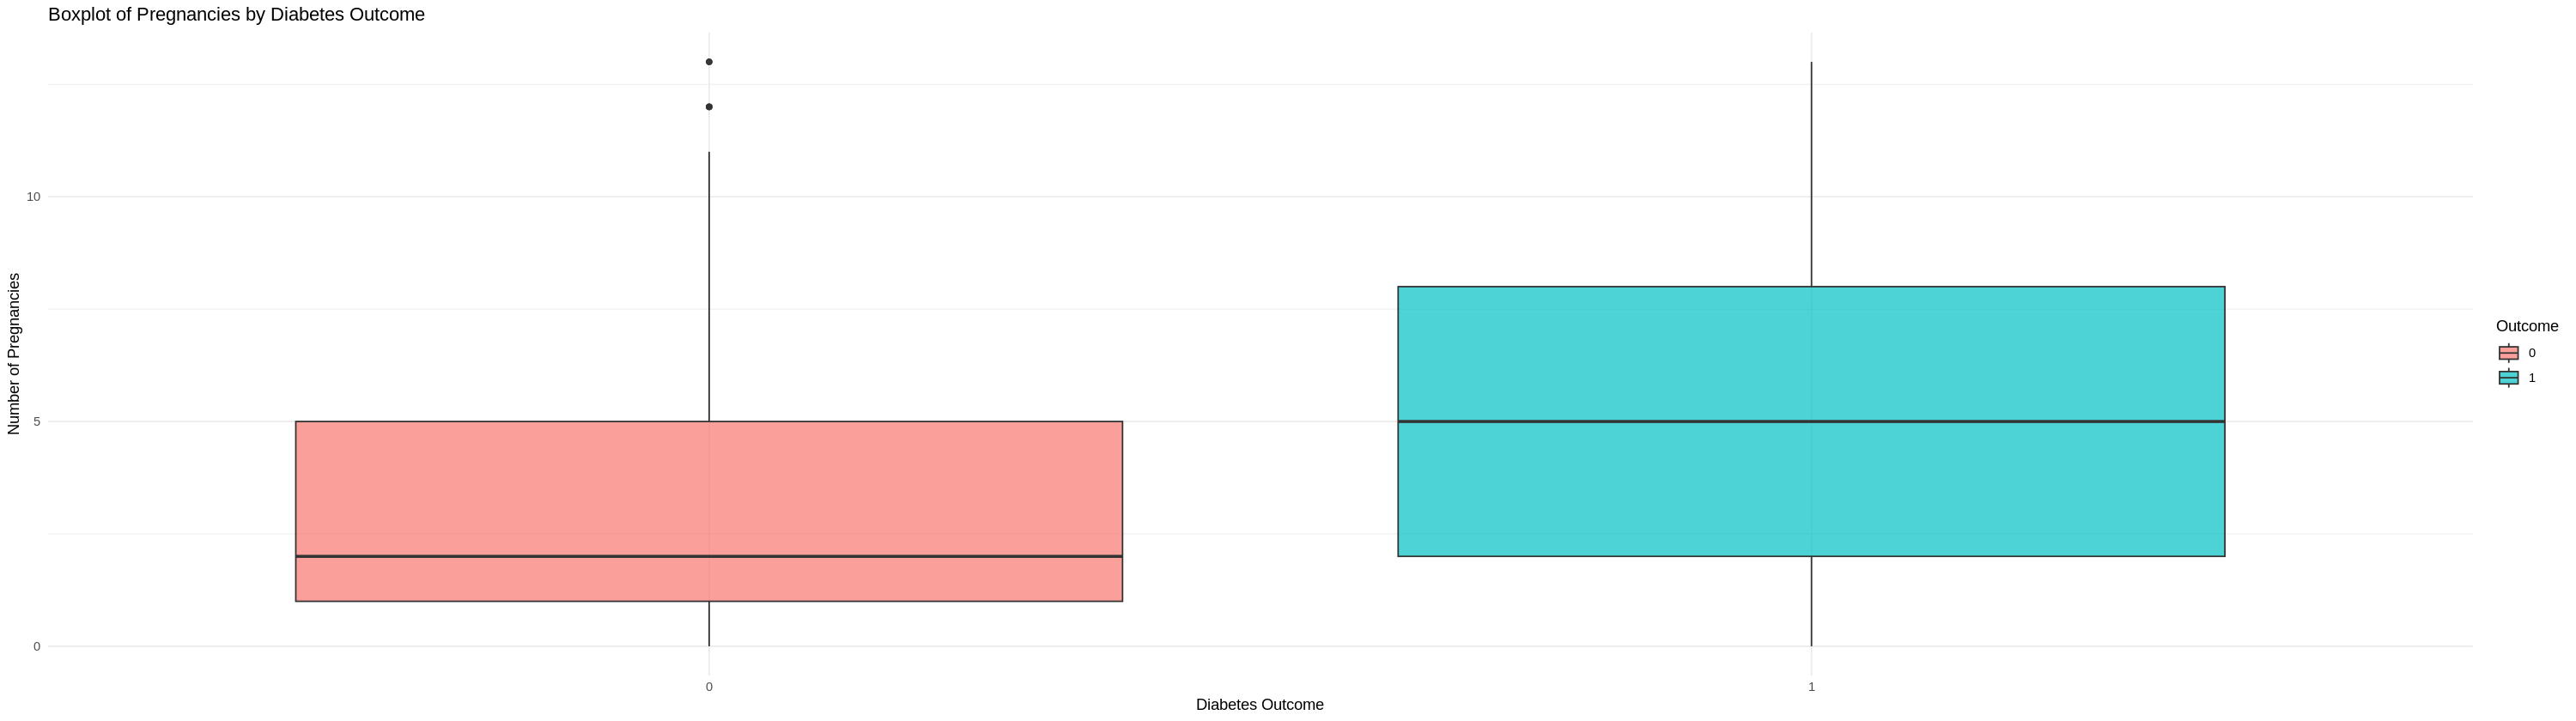

In [ ]:
ggplot(data, aes(x = as.factor(Outcome), y = Pregnancies, fill = as.factor(Outcome))) +
  geom_boxplot(alpha = 0.7) +
  labs(title = "Boxplot of Pregnancies by Diabetes Outcome",
       x = "Diabetes Outcome",
       y = "Number of Pregnancies",
       fill = "Outcome") +
  theme_minimal()

In [ ]:
correlation <- cor.test(data$Pregnancies, data$Outcome)
correlation


	Pearson's product-moment correlation

data:  data$Pregnancies and data$Outcome
t = 6.2102, df = 699, p-value = 9.081e-10
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1572795 0.2976758
sample estimates:
      cor 
0.2286663 


**Correlation Coefficient (cor = 0.2287):**
* The correlation coefficient indicates a weak positive relationship between the number of pregnancies and the Outcome variable.
* A value of 0.2287 means that as the number of pregnancies increases, the likelihood of the Outcome being 1 (or positive) slightly increases, but the relationship is not strong.

**Statistical Significance (p-value = 9.081e-10):**
* The extremely small p-value (< 0.05) indicates that the correlation is statistically significant, meaning the observed relationship is unlikely to be due to chance.

**Test Statistic (t = 6.2102, df = 699):**
* The high t-value further supports the conclusion that the relationship between pregnancies and Outcome is statistically significant.

**Conclusion:**
* There is a **statistically significant, weak positive** correlation between the number of pregnancies and the Outcome variable. While there is a relationship, it is not strong, suggesting that pregnancies have only a limited impact on predicting the Outcome.

### 2.1.4. Are older patients more likely to have higher insulin concentrations and blood glucose levels?


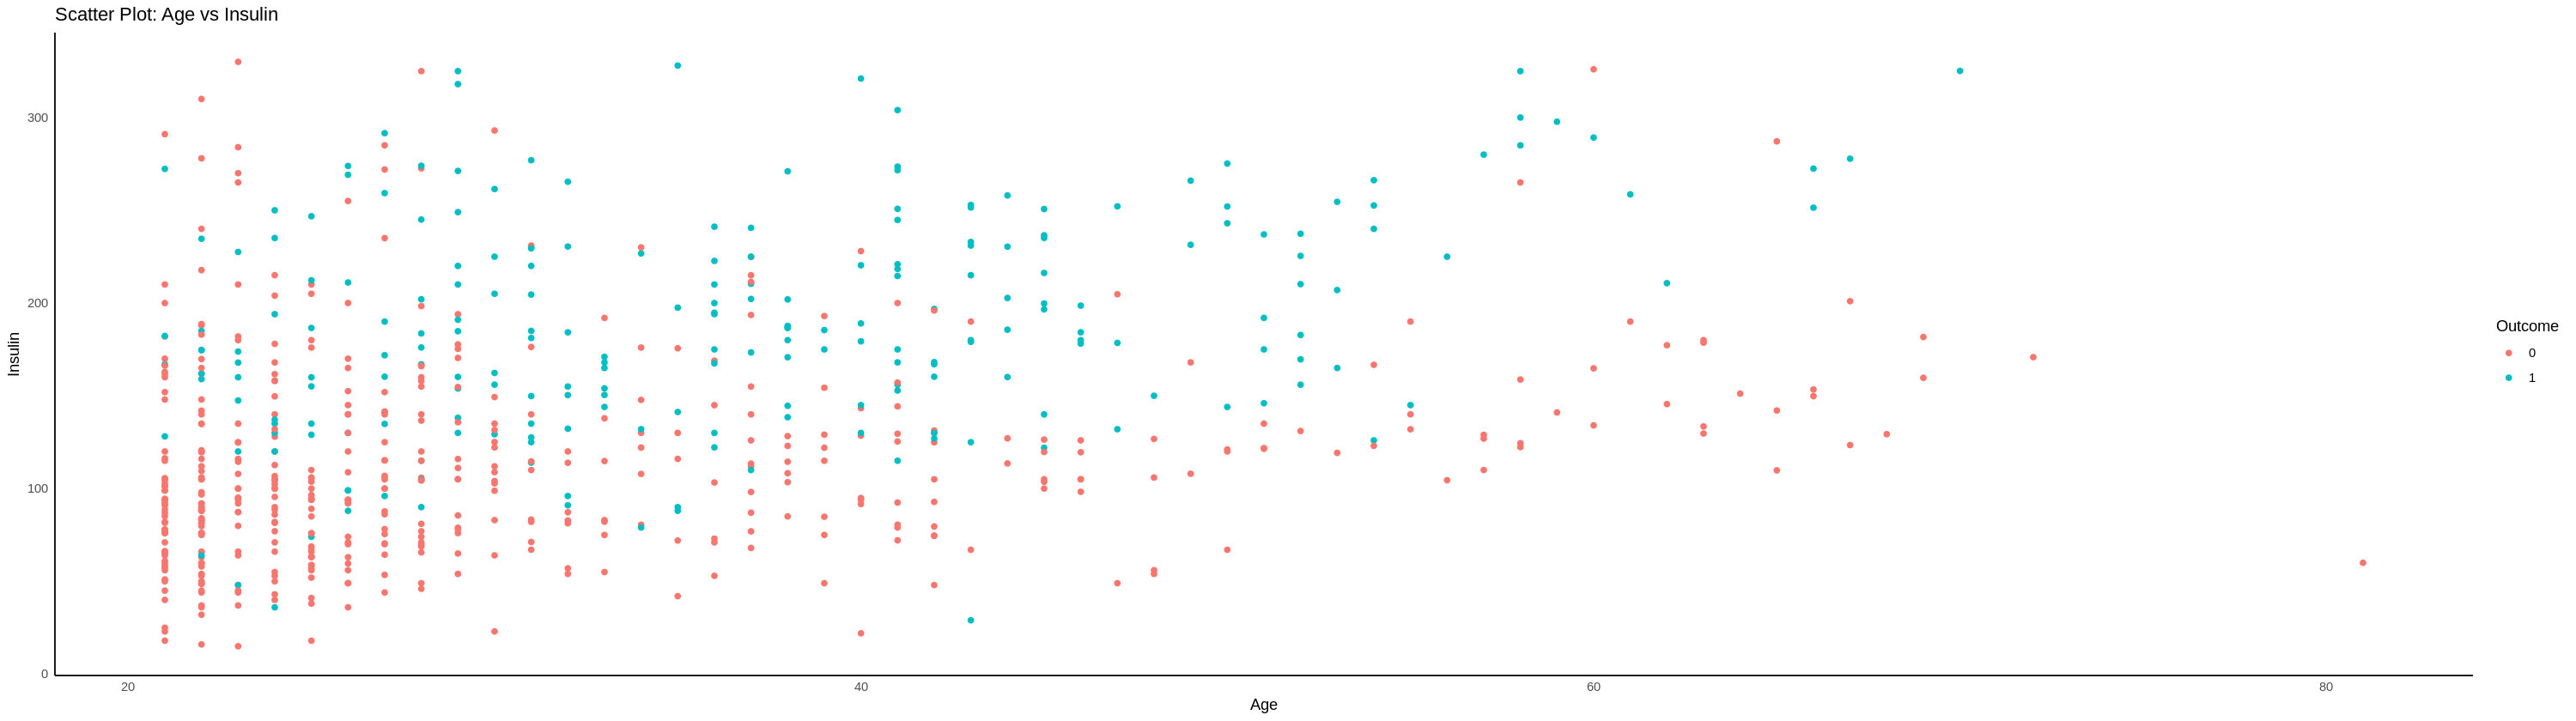

In [ ]:
ggplot(data, aes(x = Age, y = Insulin, color = as.factor(Outcome))) +
  geom_point() +
  labs(title = "Scatter Plot: Age vs Insulin",
       x = "Age",
       y = "Insulin",
       color = "Outcome") +
  theme_minimal()+
  theme(
    panel.grid = element_blank(),
    axis.line = element_line(color = "black")
  )

There is a very slight positive correlation between age and insulin levels, suggesting that older patients may be somewhat more likely to have higher insulin concentrations.

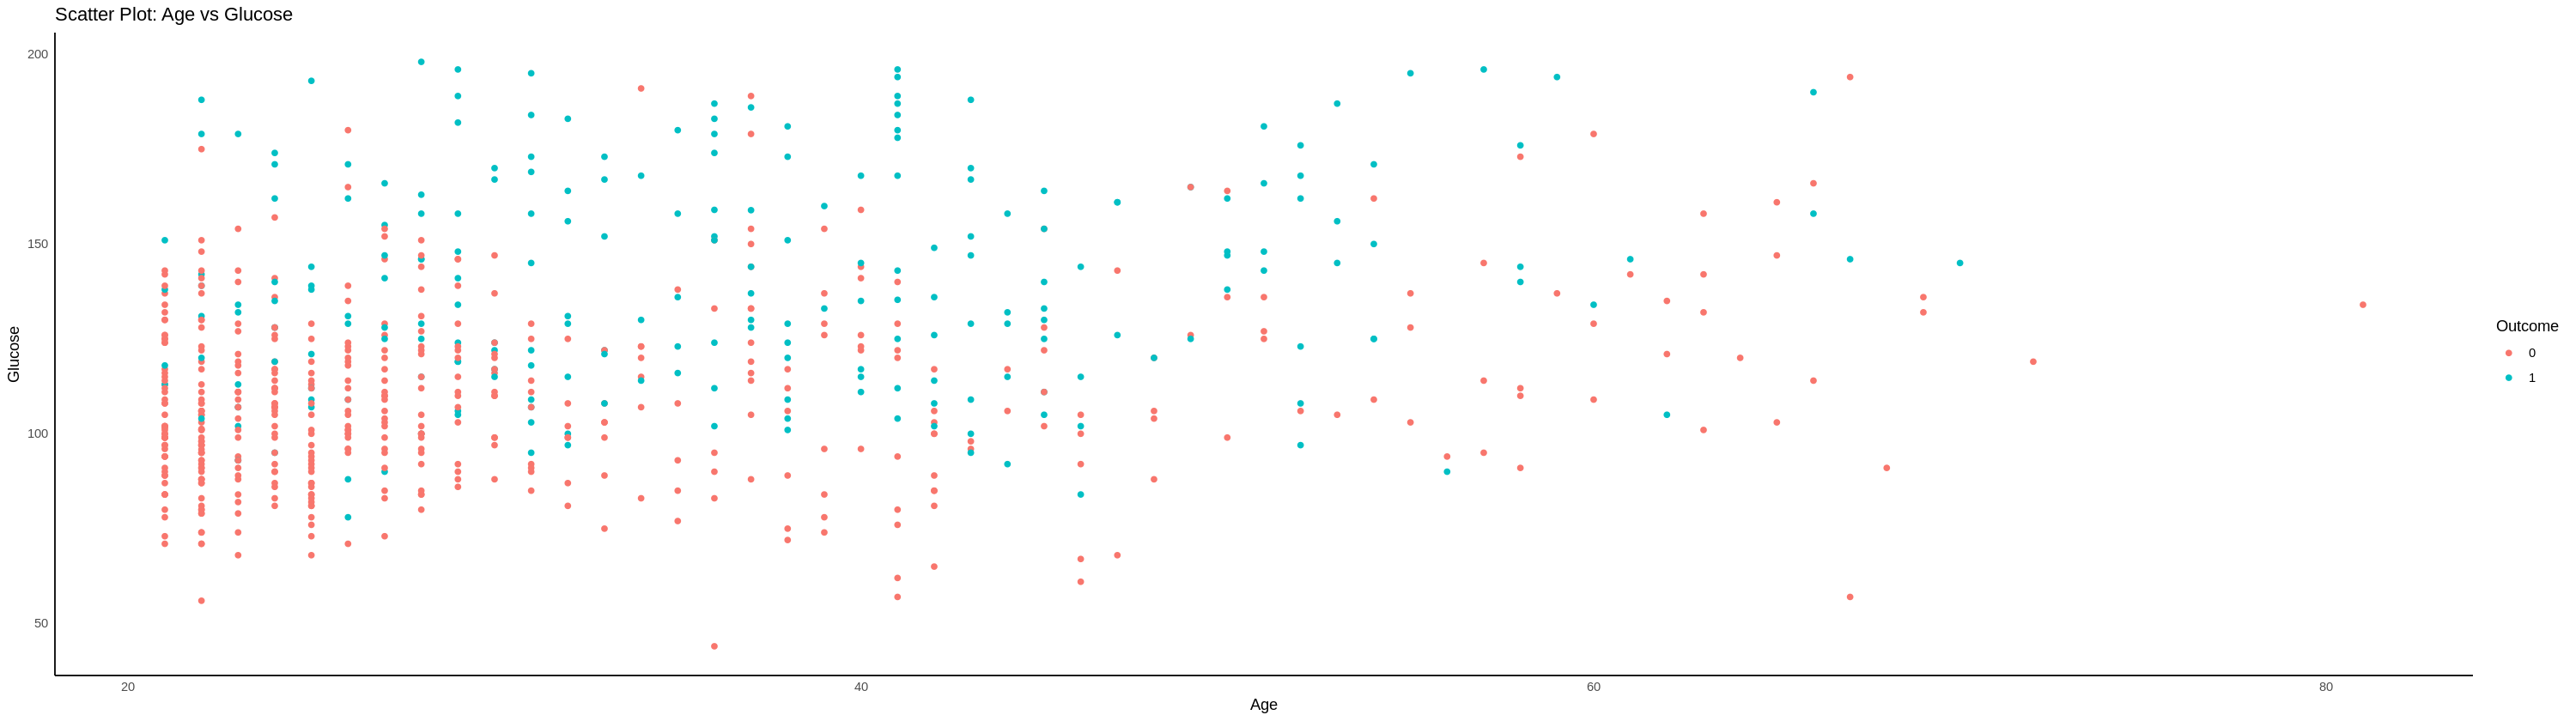

In [ ]:
ggplot(data, aes(x = Age, y = Glucose, color = as.factor(Outcome))) +
  geom_point() +
  labs(title = "Scatter Plot: Age vs Glucose",
       x = "Age",
       y = "Glucose",
       color = "Outcome") +
  theme_minimal()+
  theme(
    panel.grid = element_blank(),
    axis.line = element_line(color = "black")
  )

There is even smaller positive correlation between age and blood glucose levels, suggesting that older patients may be somewhat more likely to have higher blood glucose levels.

Linear Regression for Insulin and age

In [ ]:
lm_insulin <- lm(Insulin ~ Age, data = data)
summary(lm_insulin)


Call:
lm(formula = Insulin ~ Age, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-170.80  -48.92  -14.45   40.58  210.58 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  75.2560     7.0772  10.634   <2e-16 ***
Age           1.9204     0.2014   9.533   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 62.72 on 699 degrees of freedom
Multiple R-squared:  0.1151,	Adjusted R-squared:  0.1138 
F-statistic: 90.88 on 1 and 699 DF,  p-value: < 2.2e-16


**The linear regression model is:**

Insulin = 75.2560 + 1.9204 × Age

* There is a positive and statistically significant relationship between age and insulin levels. For each additional year of age, insulin levels are expected to increase by approximately 1.92 units.
* The R-squared value of 11.5% suggests that age alone does not explain a large proportion of the variation in insulin levels, indicating that other factors likely contribute significantly to insulin levels.

Linear Regression for Glucose and age

In [ ]:
lm_glucose <- lm(Glucose ~ Age, data = data)
summary(lm_glucose)


Call:
lm(formula = Glucose ~ Age, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-86.385 -19.408  -3.671  15.354  82.329 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 95.77412    3.15772  30.330  < 2e-16 ***
Age          0.71061    0.08988   7.906 1.04e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 27.98 on 699 degrees of freedom
Multiple R-squared:  0.08208,	Adjusted R-squared:  0.08077 
F-statistic: 62.51 on 1 and 699 DF,  p-value: 1.037e-14


**The equation for the linear regression model is:**

Glucose = 95.77412 + 0.71061 × Age

* There is a significant positive relationship between age and glucose levels, as indicated by the p-value (< 0.05).
* Weak strength of the relationship: The R-squared value of 0.08208 means that only 8.21% of the variance in glucose levels is explained by age.

**Conclusion:**
* Older patients are more likely to have higher insulin concentrations and glucose levels, based on the positive correlations identified in the regression models.
* The relationships are weak, meaning age alone does not account for much of the variability in insulin or glucose levels. Other factors play a larger role.

### 2.1.5. Can you identify common “risk profiles” for diabetic patients based on key metrics (glucose, BMI, age, etc.)?

from the previous statistics we can conclude that the most to colmns associated to the outcome are Glucose and Insulin so we can cereate clusters based on them

* High Risk
* Meduim Risk
* Low Risk

Prepare data for clustering by:
* Selecting relevant variables
* Do standardizing
* Assign new cluster col to the data


In [ ]:
cluster_data <- data %>% select( Glucose, Insulin)
cluster_data_scaled <- scale(cluster_data)

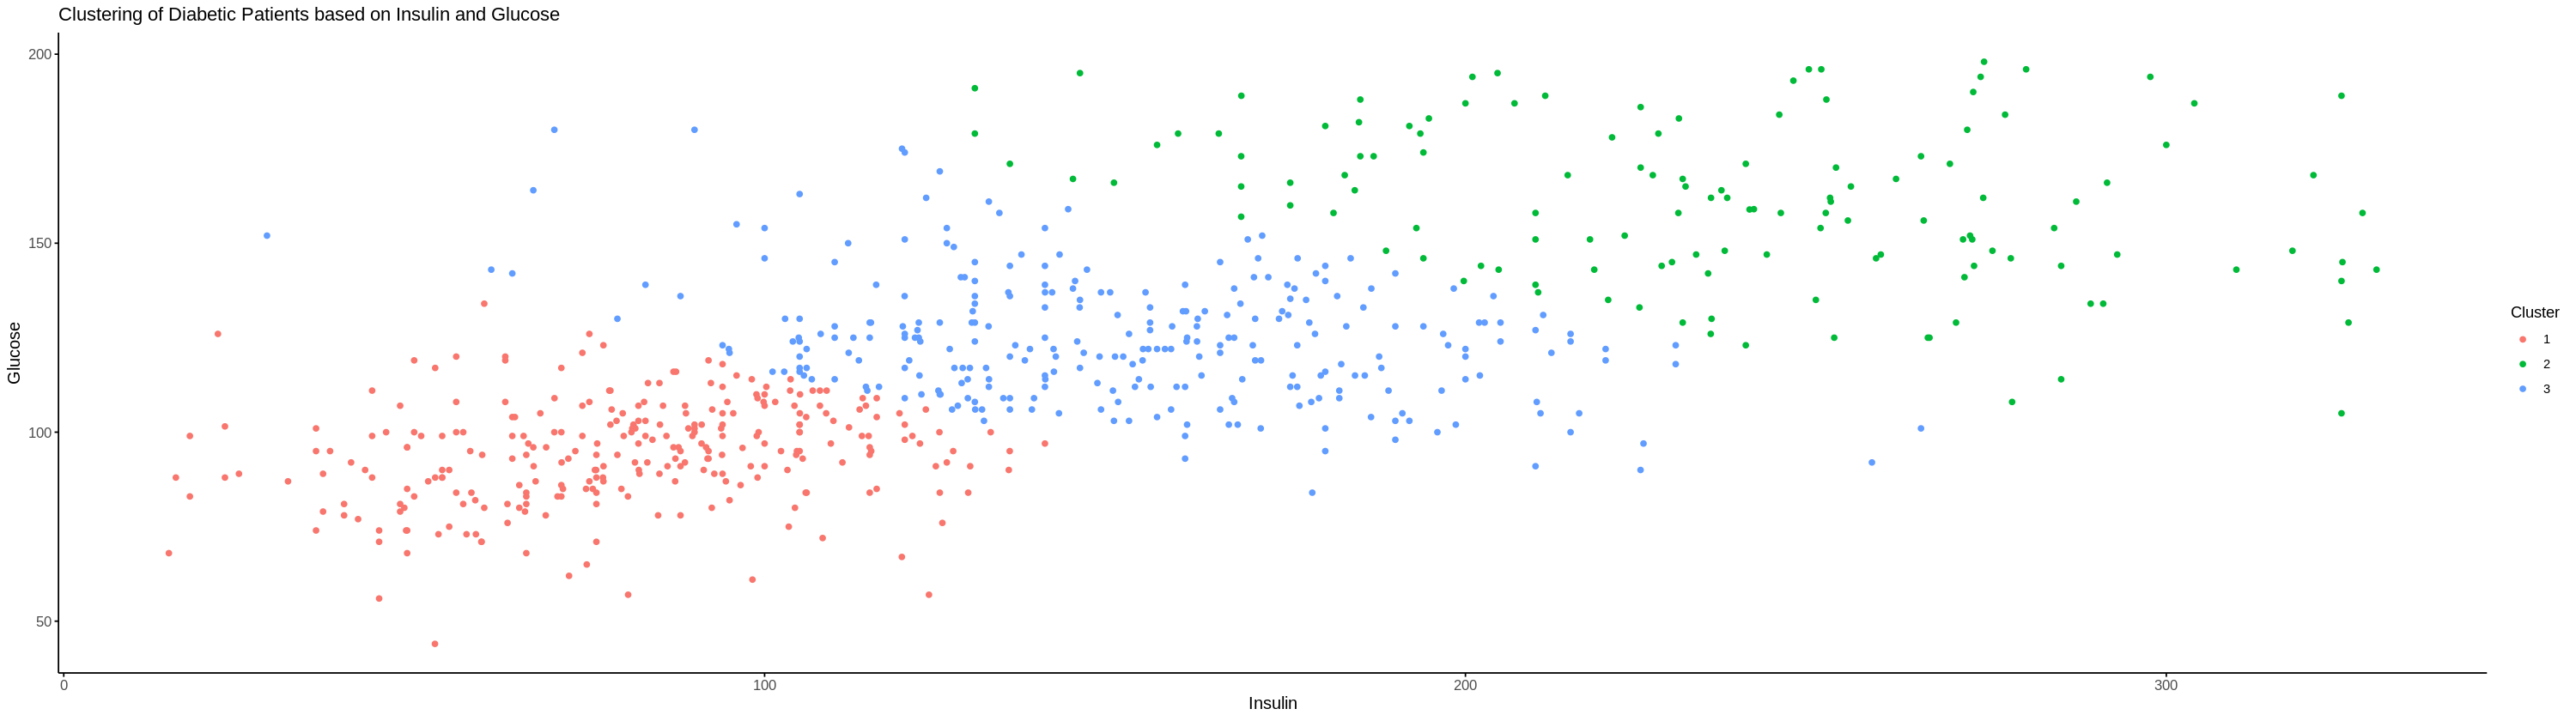

In [ ]:
set.seed(123)
kmeans_result <- kmeans(cluster_data_scaled, centers = 3)
data$cluster <- as.factor(kmeans_result$cluster)

ggplot(data, aes(x = Insulin, y = Glucose, color = cluster)) +
  geom_point() +
  labs(title = "Clustering of Diabetic Patients based on Insulin and Glucose",
       x = "Insulin", y = "Glucose", color = "Cluster") +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.line = element_line(color = "black"),
    axis.ticks = element_line(color = "black"),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10)
  )

**The clustering analysis based on insulin and glucose levels reveals three distinct groups of diabetic patients:**

* **Cluster 1** (Red): This group is characterized by relatively low insulin and glucose levels. These patients likely represent individuals with milder insulin resistance or better controlled diabetes.

* **Cluster 2** (Green): This group has high insulin and glucose levels. These individuals may have more severe insulin resistance or poorly controlled diabetes.

* **Cluster 3 (Blue):** This group falls between clusters 1 and 2, with moderate insulin and glucose levels. These patients may represent those with intermediate risk or diabetes management outcomes.

## 2.2. Come up with 5 more bivariate/multivariate analysis questions and similarly answer each with appropriate visuals and commentary.

### Glucose Distribution by Outcome

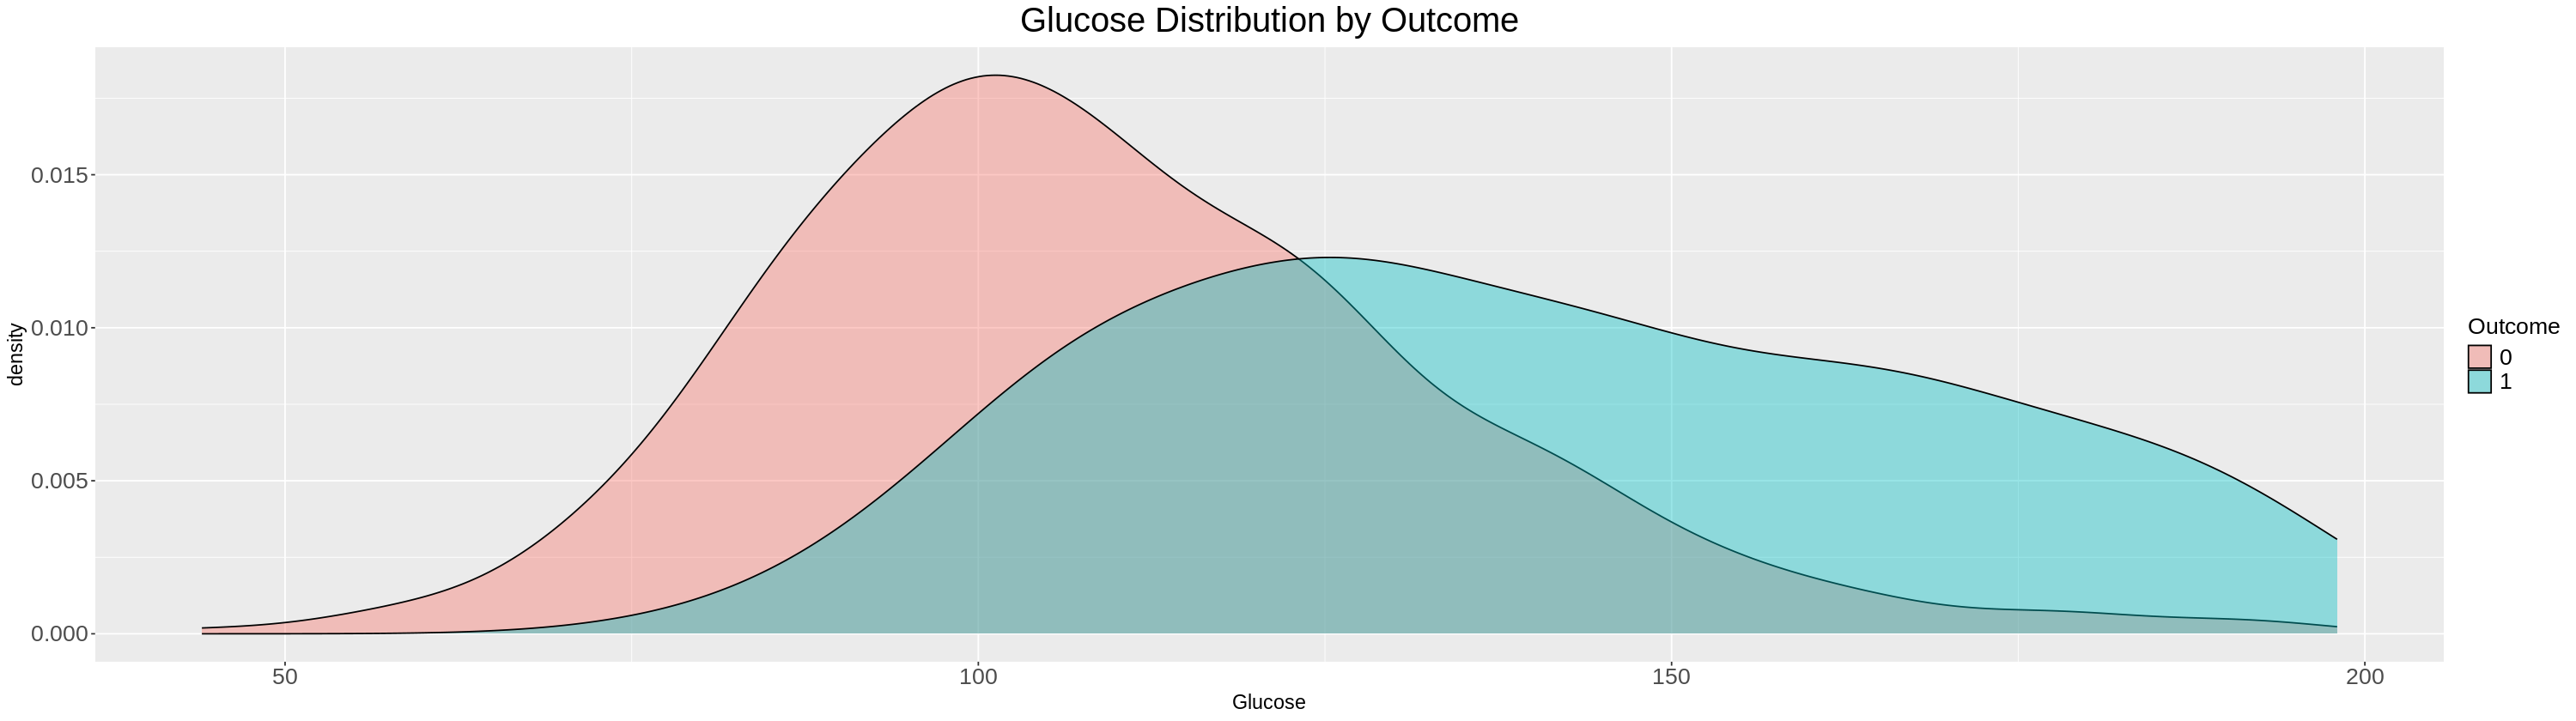

In [ ]:
library(ggplot2)

ggplot(data, aes(x = Glucose, fill = factor(Outcome))) +
  geom_density(alpha = 0.4) +
  labs(title = "Glucose Distribution by Outcome", x = "Glucose", fill = "Outcome") +
  theme(
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 16),
    plot.title = element_text(size = 24, hjust = 0.5),
    legend.text = element_text(size = 16),
    legend.title = element_text(size = 16)
  )

The red curve (for people with diabetes) skews higher. This indicates glucose level among diagnosed individuals is noticeably higher.

We can see that the red curve is dense at lower Glucose levels, while blue curve is is dense at higher Glucose levels and has a wider spread.

### Count of Age Groups by Outcome

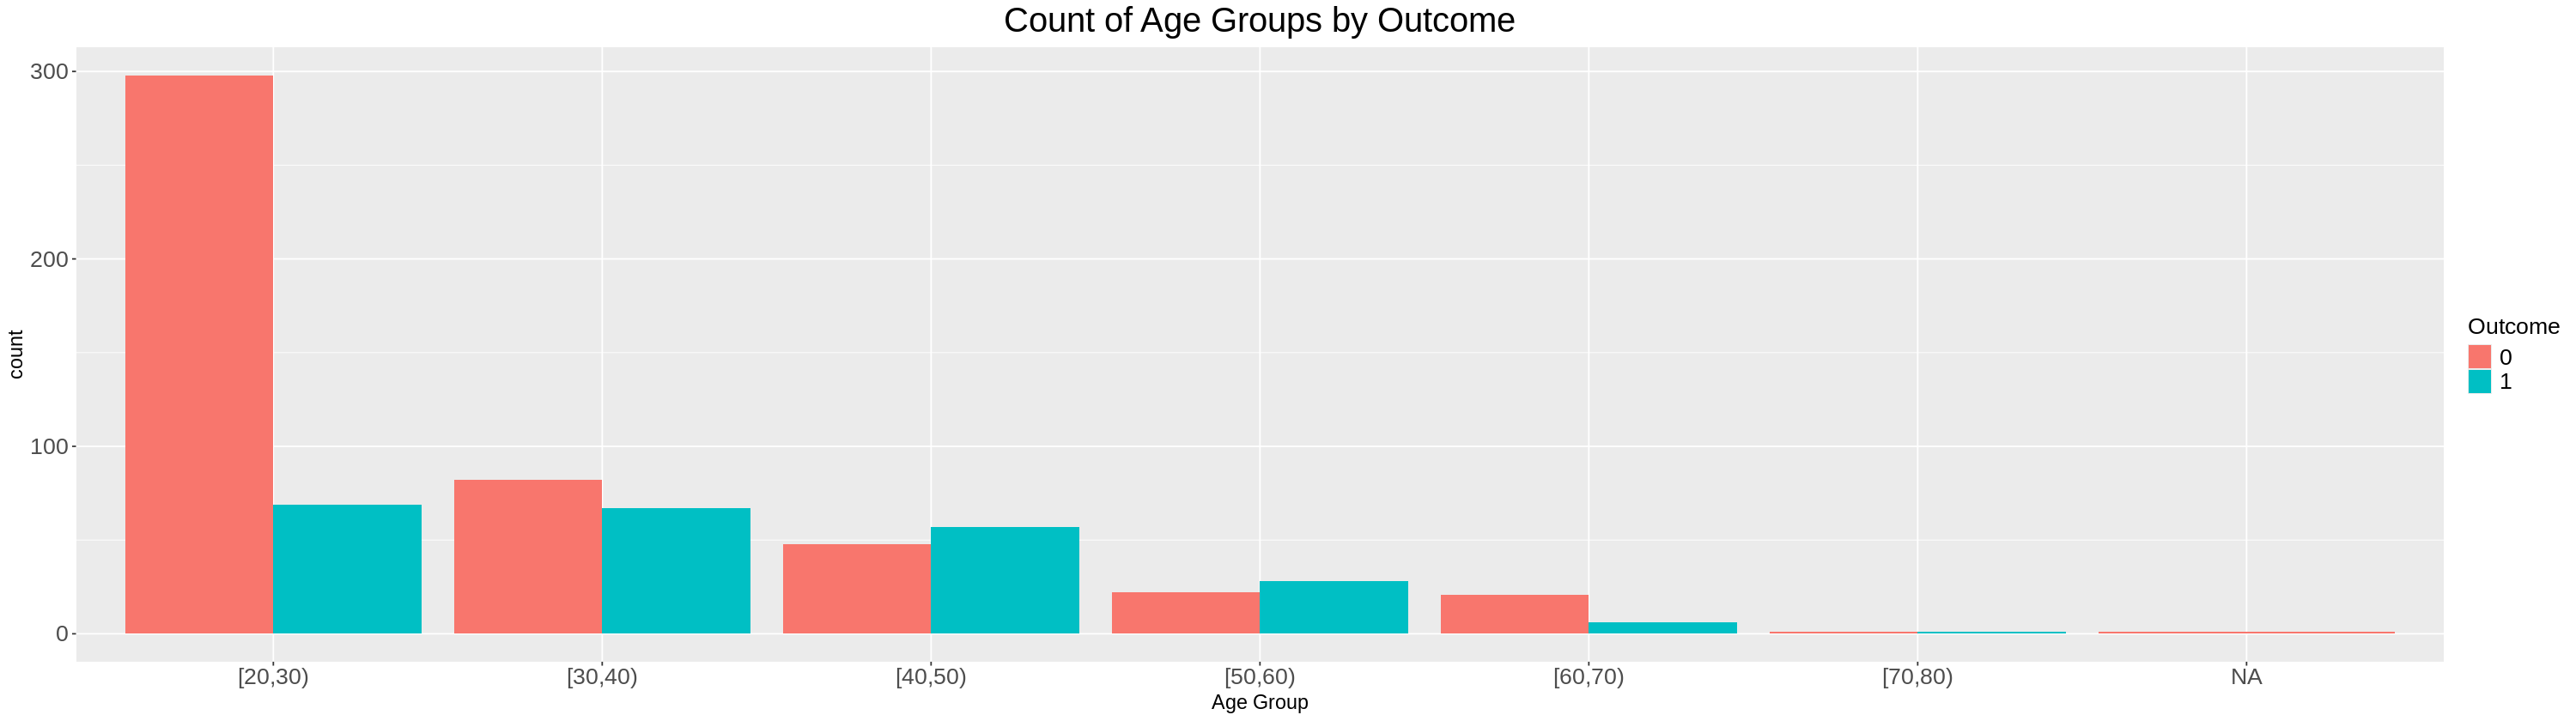

In [ ]:
data$AgeGroup <- cut(data$Age, breaks = seq(20, 85, 10), right=FALSE)

ggplot(data, aes(x = AgeGroup, fill = factor(Outcome))) +
  geom_bar(position = "dodge") +
  labs(title = "Count of Age Groups by Outcome", x = "Age Group", fill = "Outcome") +
  theme(
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 16),
    plot.title = element_text(size = 24, hjust = 0.5),
    legend.text = element_text(size = 16),
    legend.title = element_text(size = 16)
  )

This bar chart shows the count of individuals in different age groups, categorized by Outcome (0 or 1). The 20-30 age group has the most significant difference.

### Mean Glucose by Age Group & Pregnancies

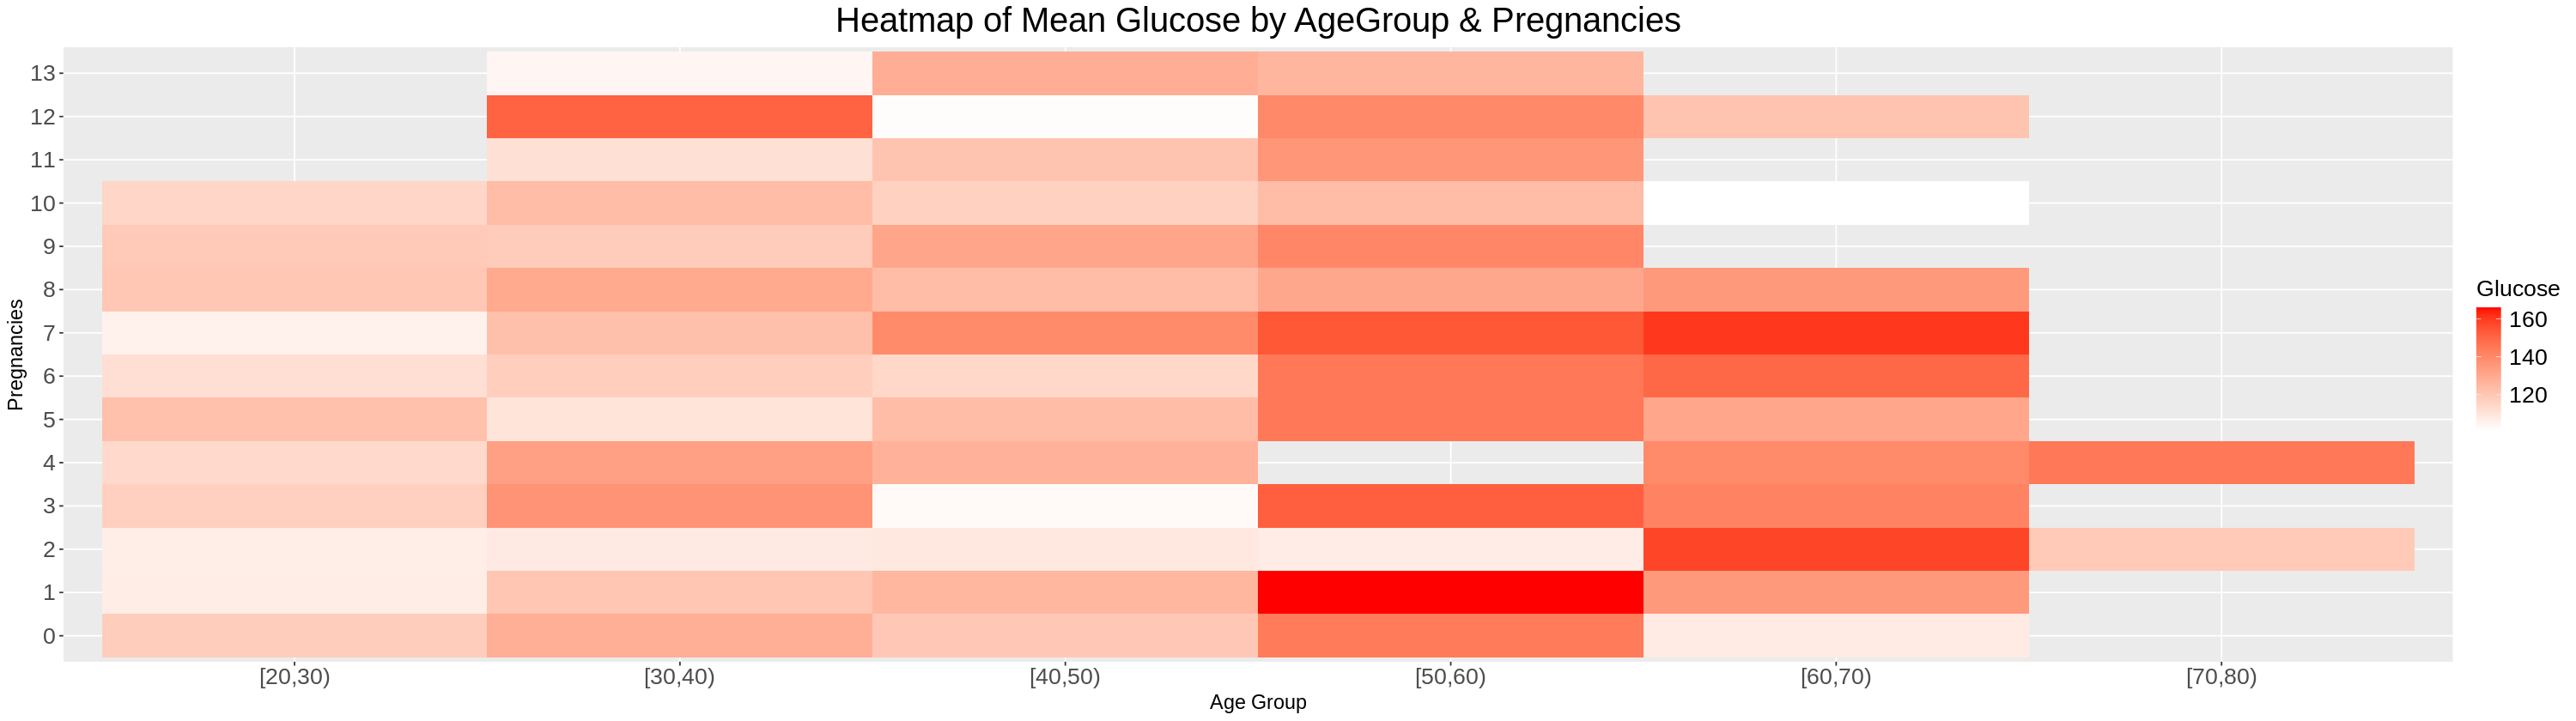

In [ ]:
agg <- aggregate(Glucose ~ AgeGroup + Pregnancies, data = data, mean)

ggplot(agg, aes(x = AgeGroup, y = factor(Pregnancies), fill = Glucose)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "red") +
  labs(title = "Heatmap of Mean Glucose by AgeGroup & Pregnancies",
       x = "Age Group", y = "Pregnancies") +
  theme(
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 16),
    plot.title = element_text(size = 24, hjust = 0.5),
    legend.text = element_text(size = 16),
    legend.title = element_text(size = 16)
  )

This heatmap visualizes the average Glucose levels across different age groups and pregnancy counts.

We notice that:
* The highest mean Glucose levels are observed in the 50-60 age group with 1 pregnancy and the 30-40 age group with 12 pregnancies.

* Generally, Glucose levels appear to increase with age for a given number of pregnancies.

### SkinThickness Distribution by Outcome

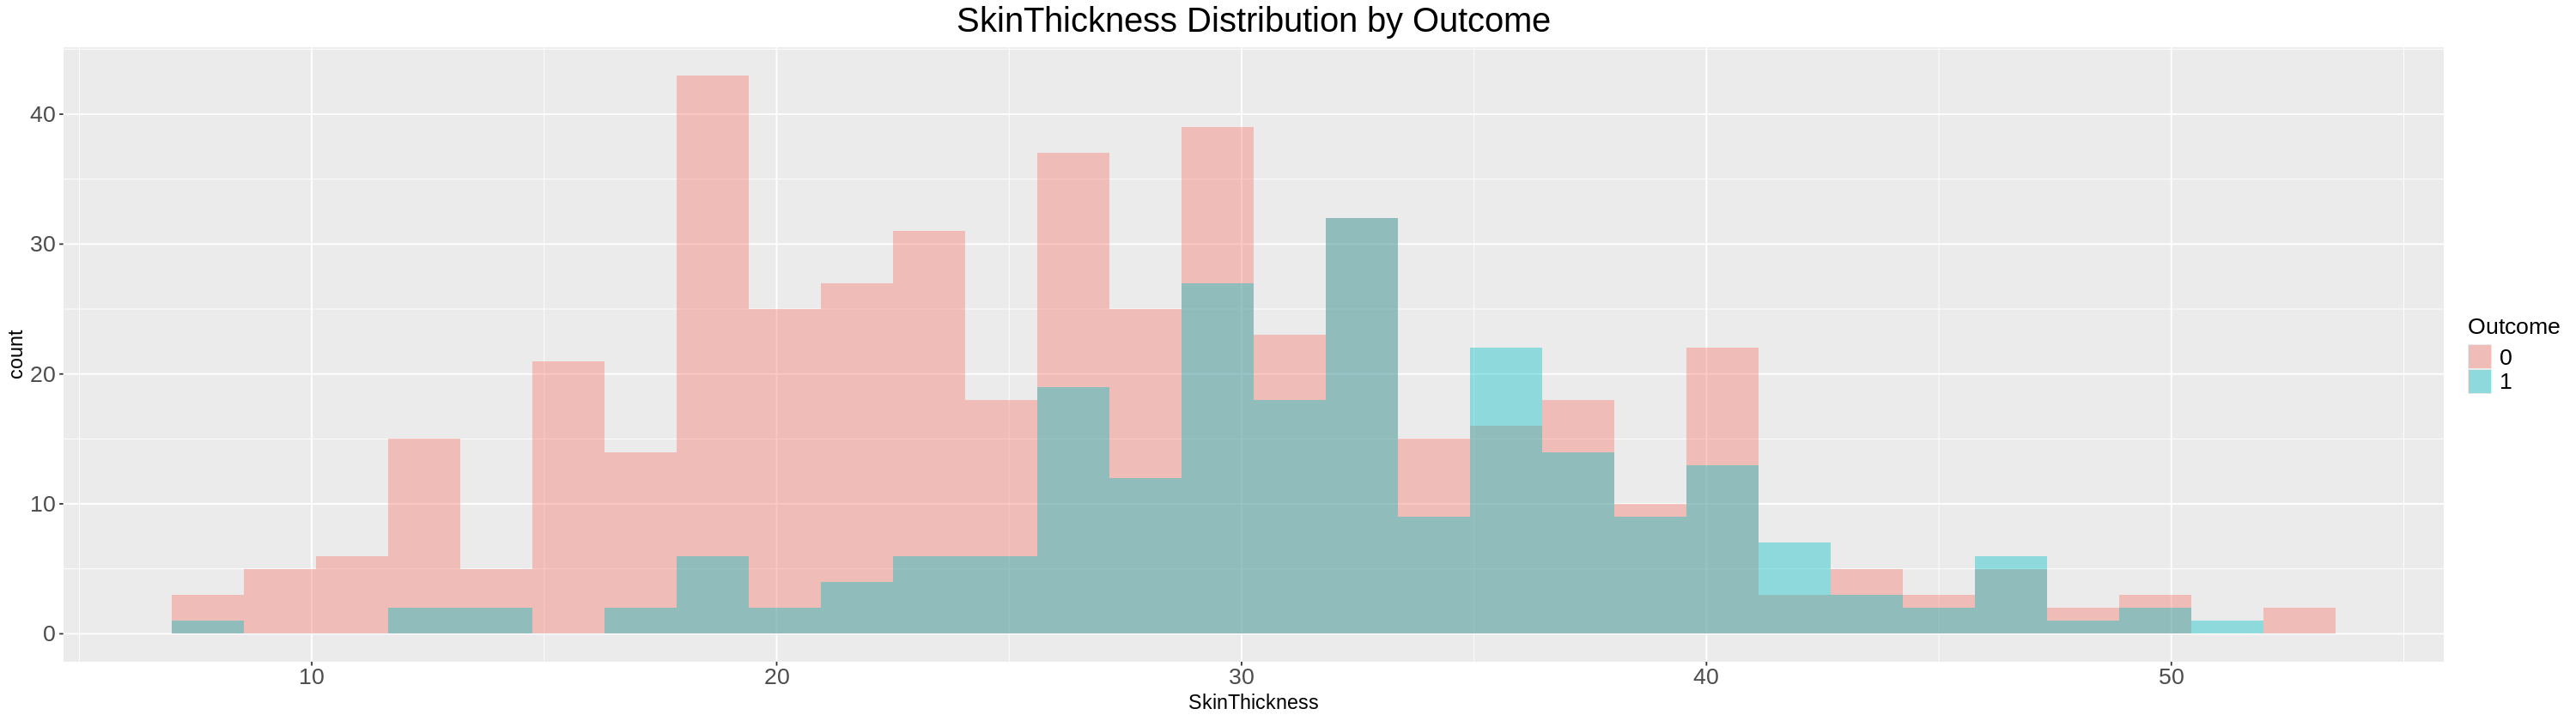

In [ ]:
ggplot(data, aes(x = SkinThickness, fill = factor(Outcome))) +
  geom_histogram(position = "identity", alpha = 0.4, bins = 30) +
  labs(title = "SkinThickness Distribution by Outcome",
       fill = "Outcome") +
  theme(
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 16),
    plot.title = element_text(size = 24, hjust = 0.5),
    legend.text = element_text(size = 16),
    legend.title = element_text(size = 16)
  )

This histogram shows the distribution of SkinThickness for people with diabetes and people without. The graph shows that people with diabetes tend to have higher SkinThickness values.

### BMI and Age vs. Diabetes Outcome

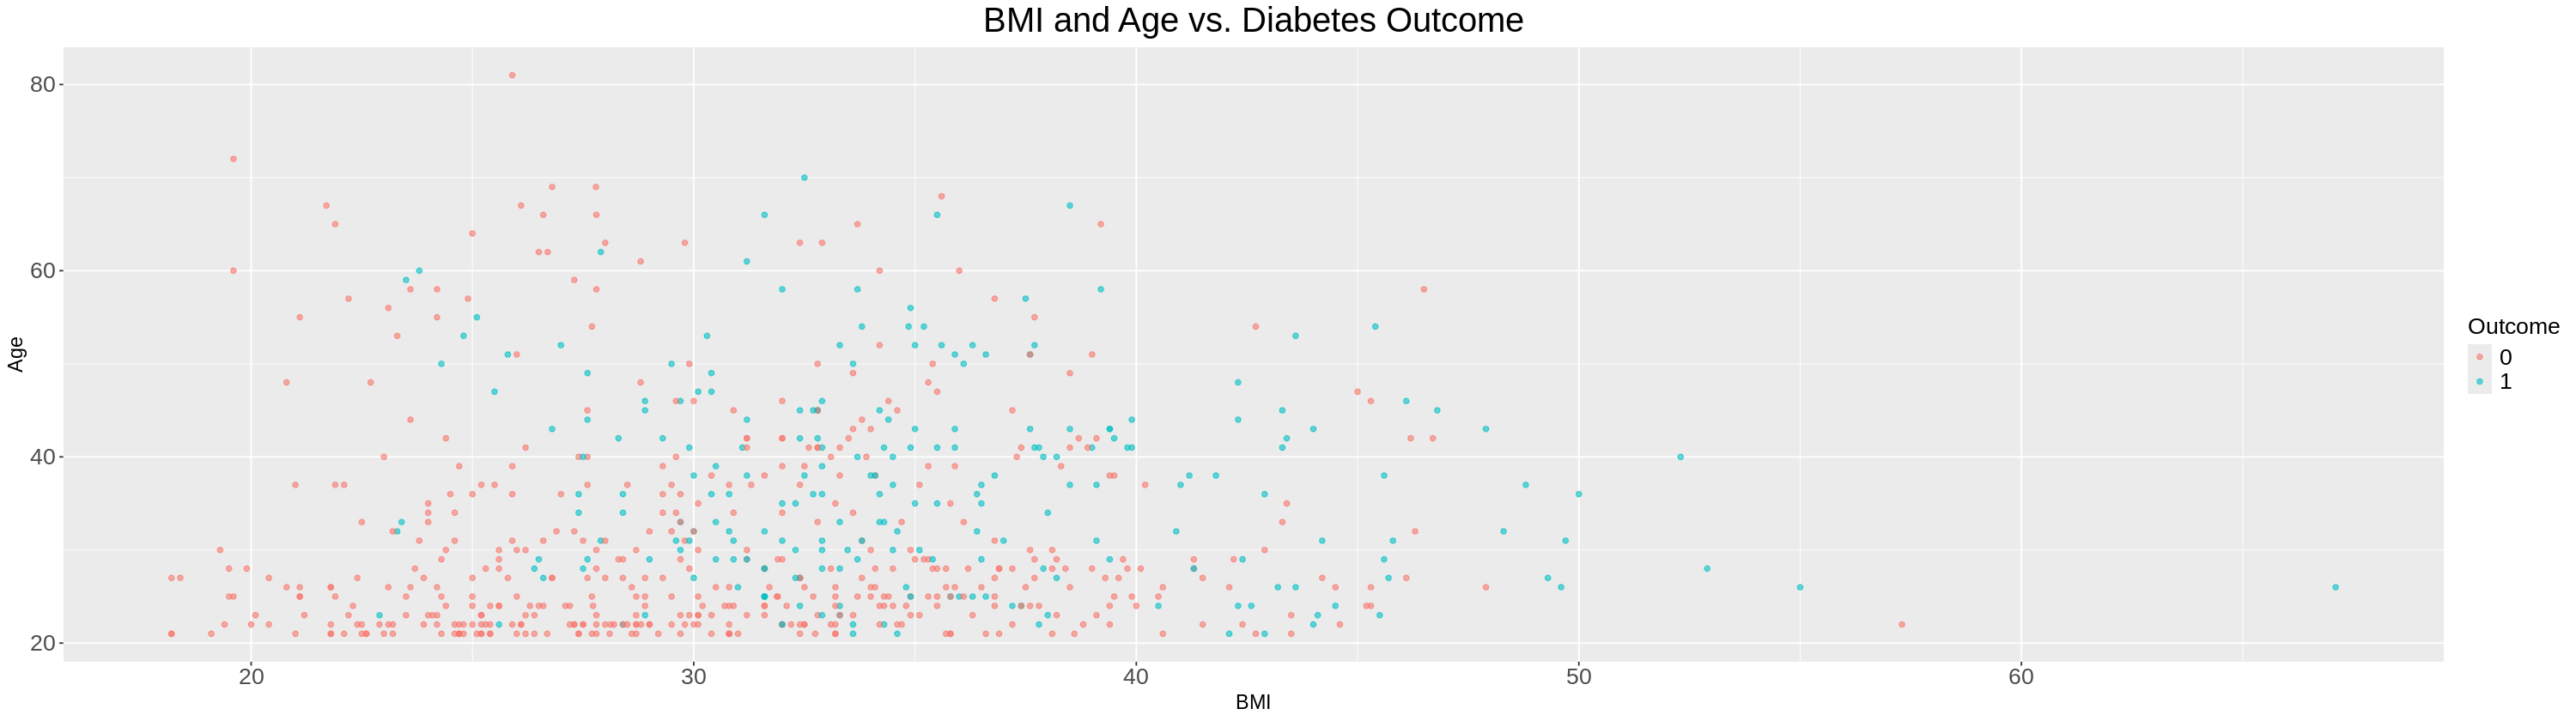

In [ ]:
ggplot(data, aes(x = BMI, y = Age, color = factor(Outcome))) +
  geom_point(alpha = 0.6) +
  labs(title = "BMI and Age vs. Diabetes Outcome",
       x = "BMI",
       y = "Age",
       color = "Outcome")+
  theme(
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 16),
    plot.title = element_text(size = 24, hjust = 0.5),
    legend.text = element_text(size = 16),
    legend.title = element_text(size = 16)
  )

Individuals with diabetes generally have higher BMI and are older than those without. This suggests higher BMI and older age may be associated with increased diabetes risk.


### BMI Distribution by Diabetes Outcome and Age Group

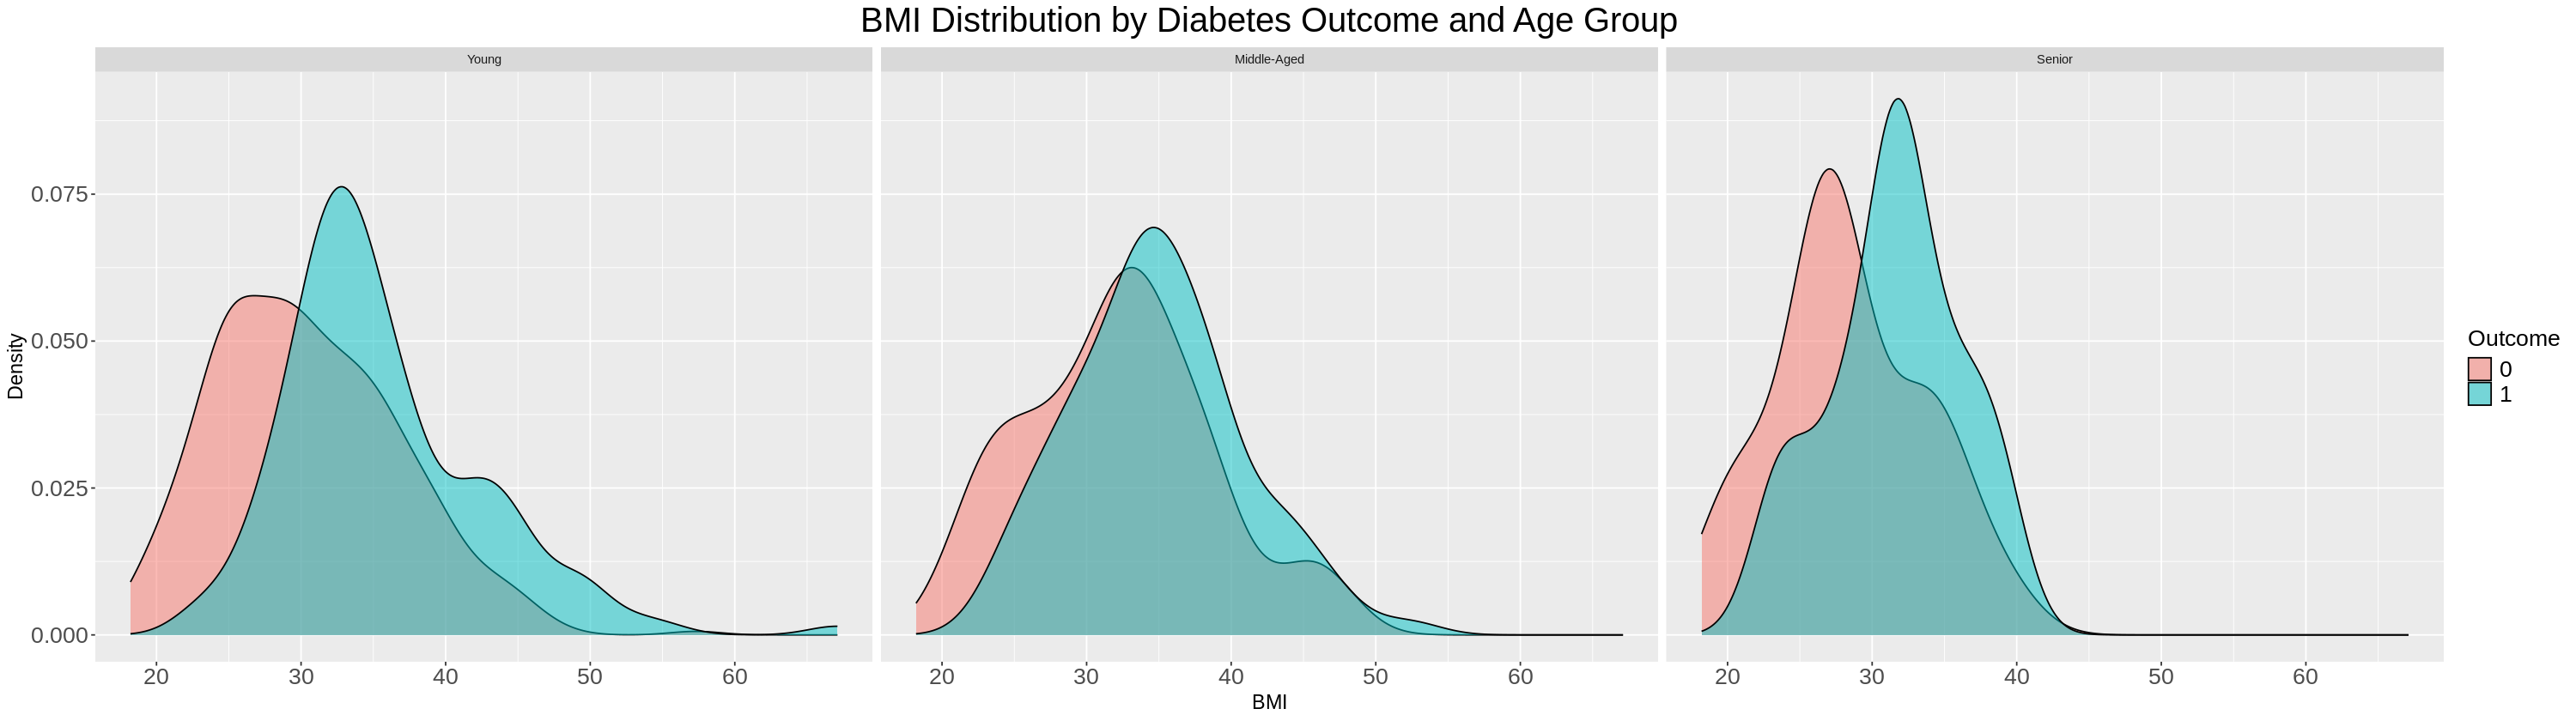

In [ ]:
data$AgeGroup <- cut(data$Age, breaks = c(20, 40, 60, 85),
                     labels = c("Young", "Middle-Aged", "Senior"), right = FALSE)

ggplot(data, aes(x = BMI, fill = factor(Outcome))) +
  geom_density(alpha = 0.5) +
  facet_wrap(~ AgeGroup) +
  labs(title = "BMI Distribution by Diabetes Outcome and Age Group",
       x = "BMI",
       y = "Density",
       fill = "Outcome") +
  theme(
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 16),
    plot.title = element_text(size = 24, hjust = 0.5),
    legend.text = element_text(size = 16),
    legend.title = element_text(size = 16)
  )

The BMI distribution differs between outcome groups. Individuals with diabetes tend to have higher BMI in these age groups. In the "Senior" group, the difference is less pronounced.

### Glucose vs. Insulin

`geom_smooth()` using formula = 'y ~ x'


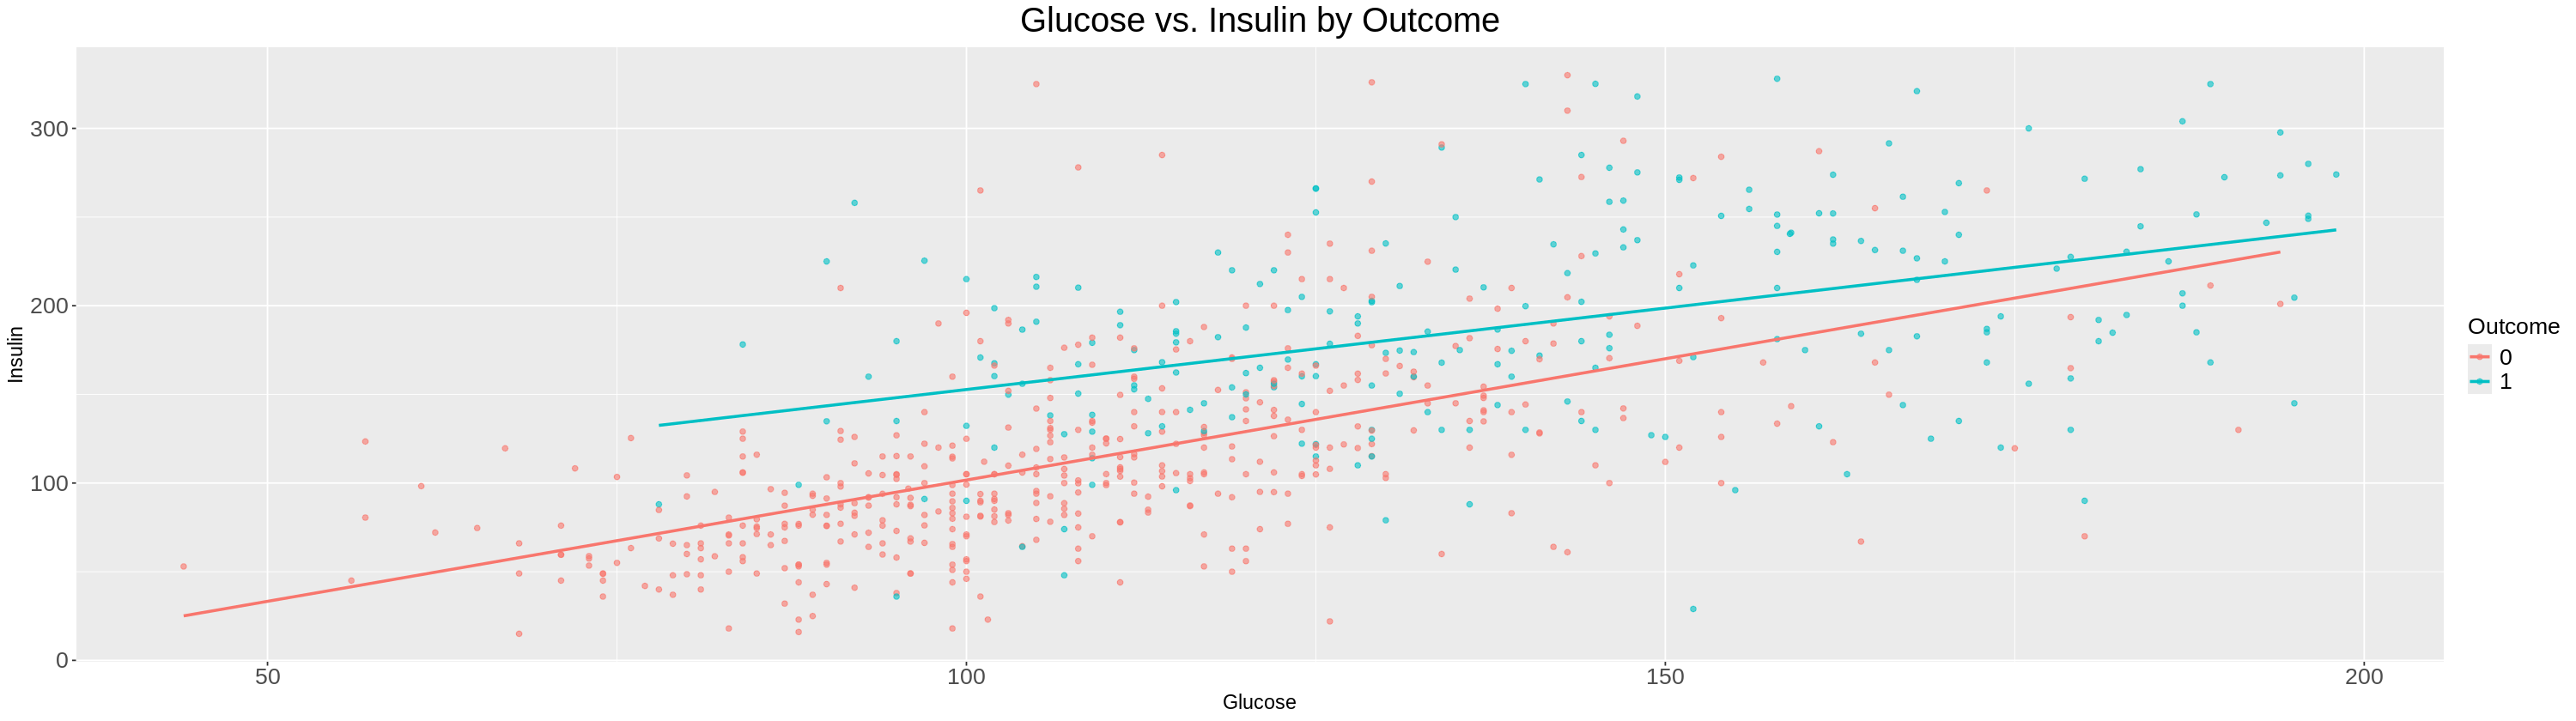

In [ ]:
ggplot(data, aes(x = Glucose, y = Insulin, color = factor(Outcome))) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", se = FALSE) +
  labs(title = "Glucose vs. Insulin by Outcome",
       x = "Glucose",
       y = "Insulin",
       color = "Outcome") +
  theme(
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 16),
    plot.title = element_text(size = 24, hjust = 0.5),
    legend.text = element_text(size = 16),
    legend.title = element_text(size = 16)
  )

This scatter plot shows the relationship between Glucose and Insulin, with trend lines. People with diabetes show a smoother positive relationship between Glucose and Insulin compared to people without. This suggests that for a given increase in Glucose, people without diabetes tend to have a larger increase in Insulin.

# PART 3: Hypothesis Testing

**Splitting patients**

In [ ]:
nonDiabetic<-subset(data, Outcome == "0") # getting nonDiabetic patients
diabetic<-subset(data, Outcome == "1") # getting diabetic patients

##*Claim:There is a significant difference in glucose levels between diabetic and non-diabetic patients.*

* $H_0:μ_{\\{diabetic}} = μ_{\\{non-diabetic}}$





* $H_a:μ_{\\{diabetic}} \neq μ_{\\{non-diabetic}}$

In [ ]:
# Getting Glucose column only
nonDiabeticGlucose<-nonDiabetic['Glucose']
diabeticGlucose<-diabetic['Glucose']

**Testing**

*The t-test will be chosen as it is able to deal with:*
* Type of data: Continuous data, which is on glucose level, Blood Pressure, etc.
* Nature of comparison: Comparison of mean values between groups.

In [ ]:
testGlucose <- t.test(diabeticGlucose,  # Glucose values for diabetic patients
                      nonDiabeticGlucose, # Glucose values for nonDiabetic patients
                      alternative = "two.sided",
                      conf.level = 0.95)
testGlucose


	Welch Two Sample t-test

data:  diabeticGlucose and nonDiabeticGlucose
t = 14.195, df = 379.32, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 26.72725 35.32242
sample estimates:
mean of x mean of y 
 140.2334  109.2086 


**Results**

In [ ]:
# P Value
pGlucose <- testGlucose$p.value
cat("P Value:",sprintf("%.40f",pGlucose) ,"\n")
#Standard Error
cat("Standard Error:" ,testGlucose$stderr ,"\n")
# CI for the mean
cat("CI for the mean:", testGlucose$conf.int ,"\n")
#Estimate
cat("Estimate:" ,testGlucose$estimate ,"\n")

P Value: 0.0000000000000000000000000000000000005600 
Standard Error: 2.18569 
CI for the mean: 26.72725 35.32242 
Estimate: 140.2334 109.2086 


**Signifiance Level**

In [ ]:
significanceLevel <- 0.05

**Decision**

In [ ]:
if (pGlucose < significanceLevel){
  print("Reject Null Hypothsis")
}else{
  print("Fail to reject Null Hypothesis (Accept Null Hypothesis)")
}

[1] "Reject Null Hypothsis"


**Conclusion**

*Since the p-value less than the significance value, there is significant diffrence between glucose levels between diabetic and non-diabetic patients.*

##*Claim: There is a significant difference in blood pressure levels between diabetic and non-diabetic patients, with diabetic patients having lower values.*
* $H_0:μ_{\\{diabetic}} = μ_{\\{non-diabetic}}$

* $H_a:μ_{\\{diabetic}} < μ_{\\{non-diabetic}}$

In [ ]:
# Getting Blood Pressure Column Only
nonDiabeticBlood<-nonDiabetic['BloodPressure']
diabeticBlood<-diabetic['BloodPressure']

**Test**

*The t-test will be chosen as it is able to deal with:*
* Type of data: Continuous data, which is on glucose level, Blood Pressure, etc.
* Nature of comparison: Comparison of mean values between groups.

In [ ]:
testBlood <- t.test(diabeticBlood, # Blood Pressure values for diabetic patients
                    nonDiabeticBlood, # Blood Pressure values for nonDiabetic patients
                    alternative = "less",
                    conf.level = 0.95)
testBlood


	Welch Two Sample t-test

data:  diabeticBlood and nonDiabeticBlood
t = 5.0308, df = 445.99, p-value = 1
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf 6.447348
sample estimates:
mean of x mean of y 
 75.62776  70.77151 


**Results**

In [ ]:
pBlood <- testBlood$p.value
cat("P Value:", pBlood, "\n")
cat("Standard Error:", testBlood$stderr, "\n")
cat("CI for the mean:", testBlood$conf.int, "\n")
cat("Estimate:", testBlood$estimate, "\n")

P Value: 0.9999996 
Standard Error: 0.9653083 
CI for the mean: -Inf 6.447348 
Estimate: 75.62776 70.77151 


**Significance Level**

In [ ]:
significanceLevel <- 0.05

**Decision**

In [ ]:
if (pBlood < significanceLevel){
  print("Reject Null Hypothsis")
}else {
  print("Fail to reject Null Hypothesis (Accept Null Hypothesis)")
}

[1] "Fail to reject Null Hypothesis (Accept Null Hypothesis)"


**Conclusion**

*Since the p-value is more than the significance value, there is no evidence to conclude that there is a significant difference having diabetic patients less than non-diabetic patients.*

# Part 4: Simulation Task

In [ ]:
col_name <- "Glucose"

population_mean <- mean(data[[col_name]])

calculate_coverage_or_ci_width <- function(data, col_name, size, num_samples, calculate_coverage){
  #' Calculate Coverage Proportion or Confidence Interval Width
  #'
  #' This function calculates either the coverage proportion or the confidence interval widths for a given sample size and number of samples.
  #'
  #' @param data A data frame containing the data from which random samples will be drawn.
  #' @param col_name A string specificng the column name to take the sample from.
  #' @param size The number of data points in each random sample.
  #' @param num_samples The number of random samples to generate
  #' @param calculate_coverage A logical (Boolean) value that determine whether the function calculates the proportion of confindece intervals or the width of the confidence intervals.
  #'
  #' @return A numeric value or vector. If calculate_coverage is TRUE, it returns the proprtion of confidence intervals that contain the population mean. If FALSE, it returns a vector of confidence interval width for each sample.

  result <- if(calculate_coverage) 0 else numeric(num_samples)

  for(i in 1:num_samples){

    sample_data <- sample(data[[col_name]], size, replace = TRUE)

    sample_mean <- mean(sample_data)
    stderr <- sd(sample_data) / sqrt(size)

    ci_lower <- sample_mean - qnorm(0.975) * stderr
    ci_upper <- sample_mean + qnorm(0.975) * stderr

    if(calculate_coverage){
      if (ci_lower <= sample_mean && ci_upper >= sample_mean){
        result <- result + 1
      }
    }
  else{
    result[i] <- ci_upper - ci_lower
  }

}
  return(if (calculate_coverage) result / num_samples else result)
}

ERROR: Error in data[[col_name]]: object of type 'closure' is not subsettable


## Calculate Coverage Proportions


In [ ]:
set.seed(123)

# Take 25 Random Samples of Size 15 from the Dataset to calculate coverage
coverage_15 <- calculate_coverage_or_ci_width(data, col_name, 15, 25, calculate_coverage = TRUE)
cat("Coverage proportion for sample size 15: ", coverage_15, "\n")
# Take 25 Random Samples of Size 100 from the Dataset to calculate coverage
coverage_100 <- calculate_coverage_or_ci_width(data, col_name, 100, 25, calculate_coverage = TRUE)
cat("Coverage proportion for sample size 100: ", coverage_100, "\n")
#Take 20 Random Samples of Size 10 from the Dataset to calculate coverage
coverage_10 <- calculate_coverage_or_ci_width(data, col_name, 10, 20, calculate_coverage = TRUE)
cat("Coverage proportion for sample size 10: ", coverage_10, "\n")

Coverage proportion for sample size 15:  0.88 
Coverage proportion for sample size 100:  0.96 
Coverage proportion for sample size 10:  0.65 


## Calculate CI Widths for Different Sample Sizes

In [ ]:
set.seed(123)
# Take 25 Random Samples of Size 15 from the Dataset to calculate CI widths
ci_widths_15 <- calculate_coverage_or_ci_width(data, col_name, 15, 25, calculate_coverage = FALSE)
cat("CI width for sample size 15: ", ci_widths_15, "\n")
# Take 25 Random Samples of Size 100 from the Dataset to calculate CI widths
ci_widths_100 <- calculate_coverage_or_ci_width(data, col_name, 100, 25, calculate_coverage = FALSE)
cat("CI width for sample size 100: ", ci_widths_100, "\n")
# Take 20 Random Samples of Size 10 from the Dataset to calculate CI widths
ci_widths_10 <- calculate_coverage_or_ci_width(data, col_name, 10, 20, calculate_coverage = FALSE)
cat("CI width for sample size 10: ", ci_widths_10)

CI width for sample size 15:  33.85001 30.30059 26.18656 30.45314 15.62111 26.45292 25.17101 25.71298 29.93617 17.50818 33.05529 37.69477 24.29532 33.88256 25.0784 29.98892 16.61344 38.49191 27.15985 40.26556 25.13086 22.47425 25.77802 20.26578 33.10736 
CI width for sample size 100:  11.5451 11.84314 10.51713 9.538241 12.26075 11.96534 10.67565 11.4609 11.86556 10.30977 12.28298 12.06589 11.55057 12.15164 12.73121 12.80016 12.49099 12.13008 10.49579 10.86249 12.14226 10.2412 11.53516 11.99309 11.27378 
CI width for sample size 10:  42.09661 15.94104 18.29533 34.44286 48.45186 30.04255 40.24375 21.61339 30.51955 26.55283 34.62578 45.72297 22.7074 43.46802 22.04357 32.51414 30.61032 40.8227 29.69387 26.23197

## Plot the Confidence Interval Widths

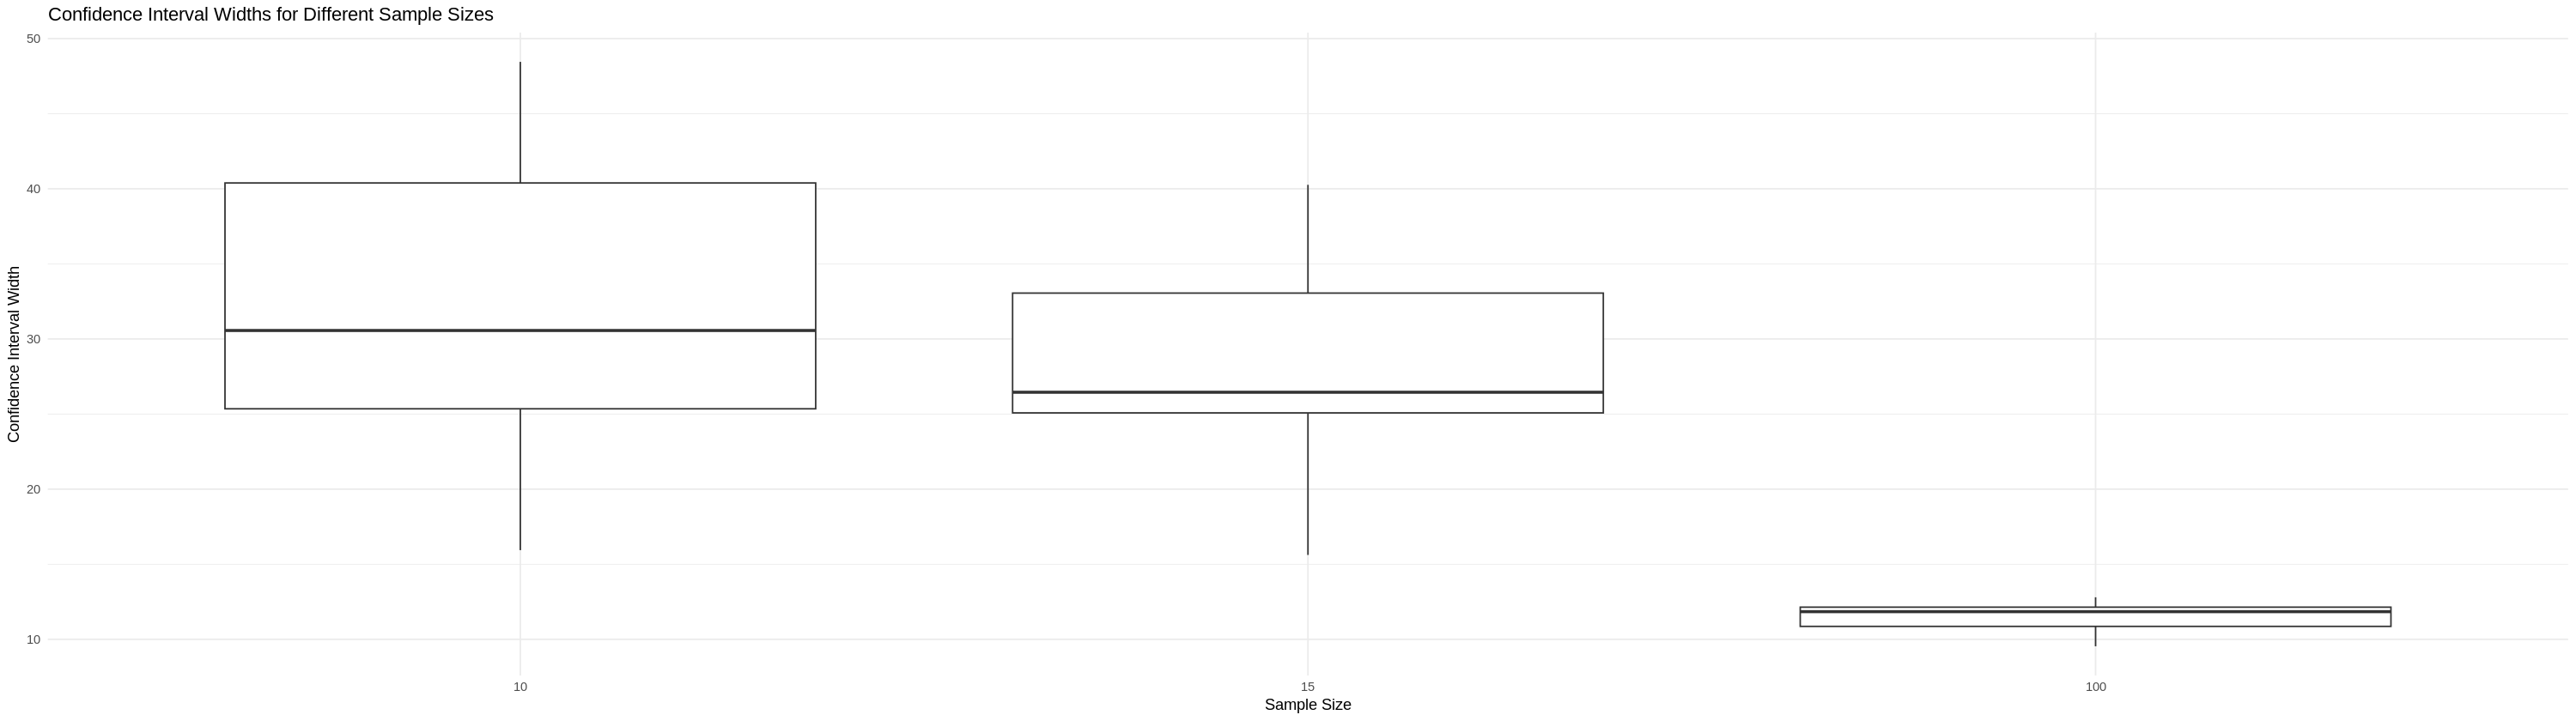

In [ ]:
ci_widths_df <- data.frame(
  SampleSize = rep(c(15, 100, 10), c(25, 25, 20)),
  CI_Width = c(ci_widths_15, ci_widths_100, ci_widths_10)
)

ggplot(ci_widths_df, aes(x = factor(SampleSize), y = CI_Width)) +
  geom_boxplot() +
  labs(title = "Confidence Interval Widths for Different Sample Sizes",
       x = "Sample Size", y = "Confidence Interval Width") +
  theme_minimal()



*  As sample size increases, the confidence interval widths decrease.



## Plot the Coverage Proportions

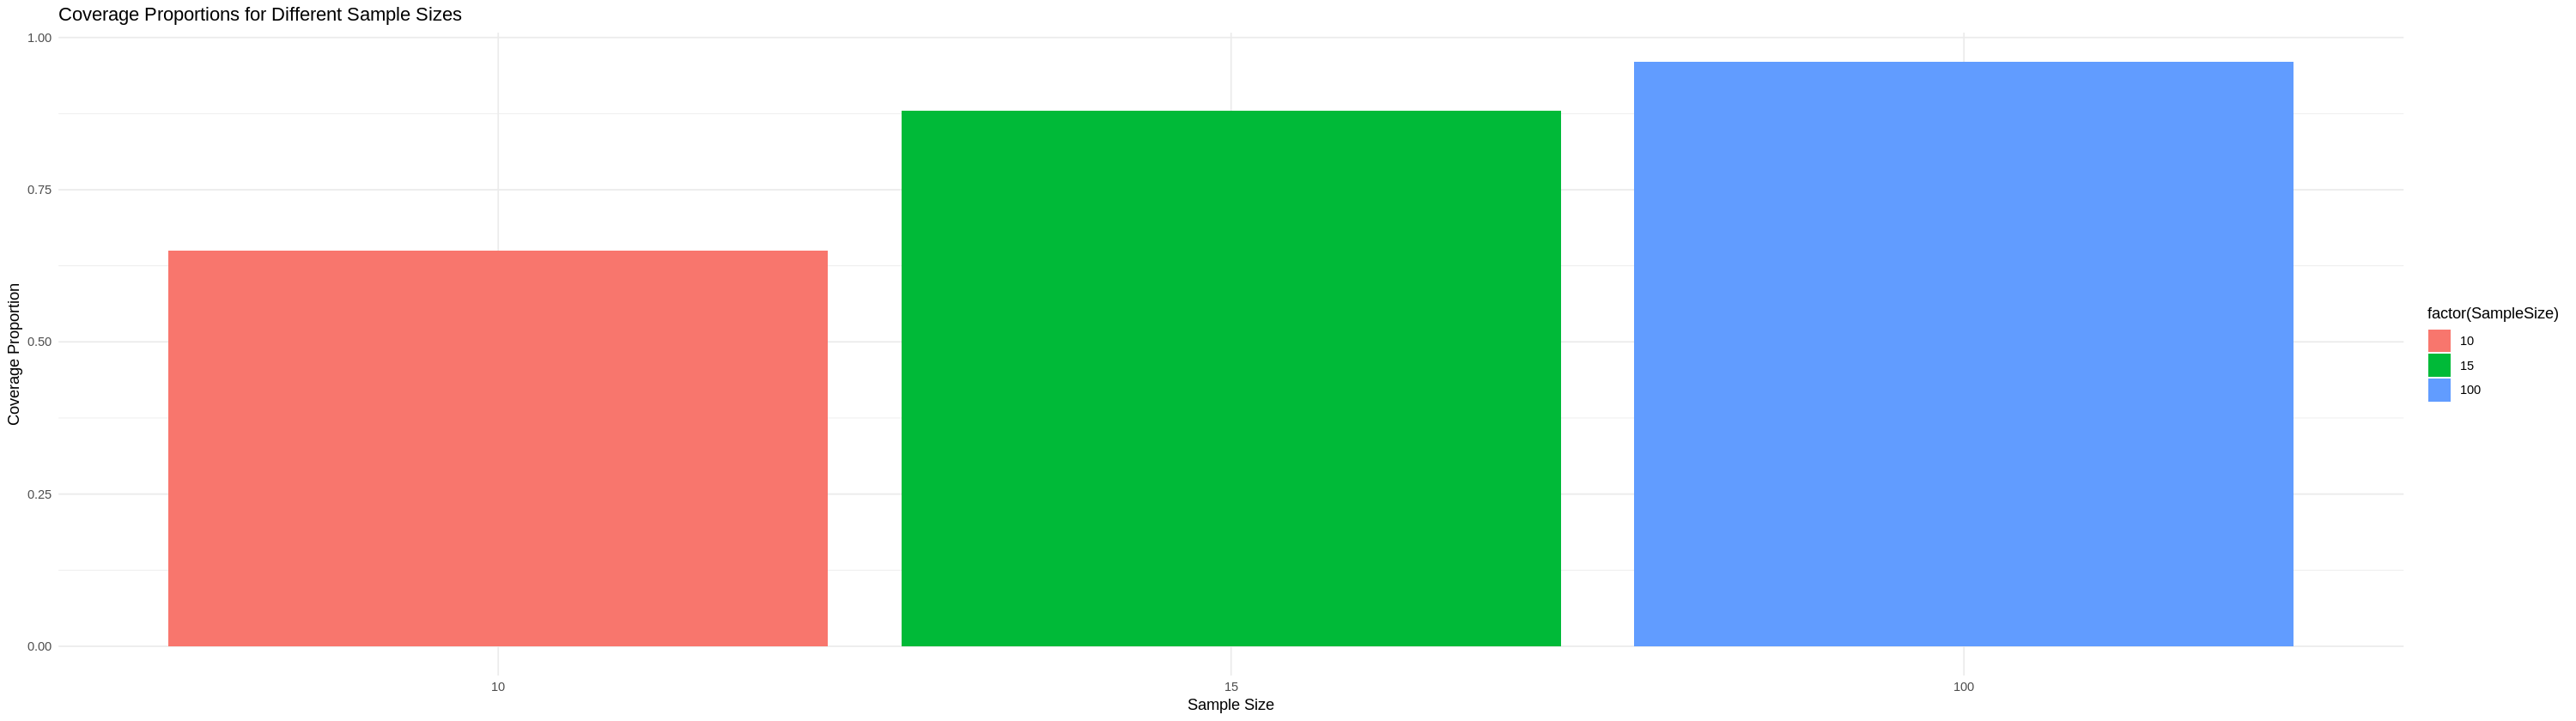

In [ ]:
coverage_data <- data.frame(
  SampleSize = c(15, 100, 10),
  Coverage = c(coverage_15, coverage_100, coverage_10)
)

ggplot(coverage_data, aes(x = factor(SampleSize), y = Coverage, fill = factor(SampleSize))) +
  geom_bar(stat = "identity") +
  labs(title = "Coverage Proportions for Different Sample Sizes",
       x = "Sample Size", y = "Coverage Proportion") +
  theme_minimal()



*  As sample size increases, the proportion of confidence intervals containing the true population mean increases.




## Compare the Findings with Actual Computation





In [ ]:
cat("Coverage Proportions:\n")
cat("Coverage for sample size 15: ", coverage_15, "\n")
cat("Coverage for sample size 100: ", coverage_100, "\n")
cat("Coverage for sample size 10: ", coverage_10, "\n")

if (coverage_15 < 0.95) {
  cat("Sample size 15: Coverage is below 95%, indicating less accuracy.\n")
}

if (coverage_100 >= 0.95) {
  cat("Sample size 100: Coverage is close to 95%, indicating more accuracy with larger samples.\n")
}

if (coverage_10 < 0.95) {
  cat("Sample size 10: Coverage is below 95%, indicating less accuracy with smaller samples.")
}

Coverage Proportions:
Coverage for sample size 15:  0.88 
Coverage for sample size 100:  0.96 
Coverage for sample size 10:  0.65 
Sample size 15: Coverage is below 95%, indicating less accuracy.
Sample size 100: Coverage is close to 95%, indicating more accuracy with larger samples.
Sample size 10: Coverage is below 95%, indicating less accuracy with smaller samples.